# **Telco Customer Churn Prediction**

### **📌 Business Case**
Telecommunications companies lose millions annually due to customer churn. Anticipating this behavior allows the company to act preventively, offering personalized benefits or solutions to keep the customer in the base.

### **🎯 Objective**
Predict whether a customer is likely to cancel service based on their contractual, demographic and usage data.

In [1]:
import pandas as pd 
from config.paths_config import *
import os
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix
from imblearn.over_sampling import SMOTE
import mlflow
import mlflow.sklearn
from sklearn.metrics import f1_score, precision_score, recall_score
from xgboost import XGBClassifier

In [2]:
data= pd.read_csv(RAW_DATA)

## **🔍 1. Data Exploration**
In this section, we will perform an initial exploration of the dataset with the goal of understanding its structure, quality, and key characteristics. This analysis is essential to identify potential consistency issues, incorrect data types, missing values, and relevant patterns that may influence predictive modeling.

### **1.1. Overview do Dataset**

In [3]:
data.shape

(7043, 21)

In [4]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
# Adjusting the data type of the Total Charges column to numeric:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

# Adjust the SeniorCitizen column to categorical:
data['SeniorCitizen'] = data['SeniorCitizen'].astype(str)

### **1.2. Check for null/missing values**

In [7]:
data.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [8]:
# replacing zero values ​​with the mean:
data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)

C:\Users\eduar\AppData\Local\Temp\ipykernel_5492\2387369211.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)


### **1.3. Check unique values ​​per column**

In [9]:
for col in data.columns:
    print(f"{col}: {data[col].nunique()} unique values")

customerID: 7043 unique values
gender: 2 unique values
SeniorCitizen: 2 unique values
Partner: 2 unique values
Dependents: 2 unique values
tenure: 73 unique values
PhoneService: 2 unique values
MultipleLines: 3 unique values
InternetService: 3 unique values
OnlineSecurity: 3 unique values
OnlineBackup: 3 unique values
DeviceProtection: 3 unique values
TechSupport: 3 unique values
StreamingTV: 3 unique values
StreamingMovies: 3 unique values
Contract: 3 unique values
PaperlessBilling: 2 unique values
PaymentMethod: 4 unique values
MonthlyCharges: 1585 unique values
TotalCharges: 6531 unique values
Churn: 2 unique values


Based on the count of unique values ​​per column, we can draw the following conclusions:

**1. Identification of categorical and numerical variables:**

- Most variables with up to 4 unique values ​​are categorical (e.g. `gender`, `Partner`, `InternetService`, `Churn`), which can be encoded with **LabelEncoder** or **OneHotEncoder**.

- The columns `MonthlyCharges`, `TotalCharges`, and `tenure` have many unique values ​​and are continuous numeric variables, suitable for statistical analysis and normalization.

**2. `customerID` column:**

- It has 7043 unique values ​​(equal to the total number of records), being a unique identifier. This column is not useful for modeling and can be discarded.

**3. Columns with 3 unique values:**

- Variables like `MultipleLines`, `OnlineSecurity`, `TechSupport`, etc., are likely to contain categories like "Yes", "No", and "No internet service" — these categories require careful preprocessing, as "No internet service" may or may not be grouped with "No" depending on the context of the model.

**4. Target variable (Churn):**

- It contains only 2 categories (Yes, No), which confirms that we are dealing with a binary classification problem.

## **📊 2. Univariate Analysis**

### **2.1. Numeric Variables**

In [10]:
def analyze_numeric_variables(df, coluna_numerica):
    plt.figure(figsize=(14, 5))

   # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[coluna_numerica], kde=True, bins=30, color='skyblue')
    plt.title(f'Histogram of {coluna_numerica}')
    plt.xlabel(coluna_numerica)
    plt.ylabel('Frequency')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[coluna_numerica], color='lightgreen')
    plt.title(f'Boxplot de {coluna_numerica}')
    plt.xlabel(coluna_numerica)

    plt.tight_layout()
    plt.show()

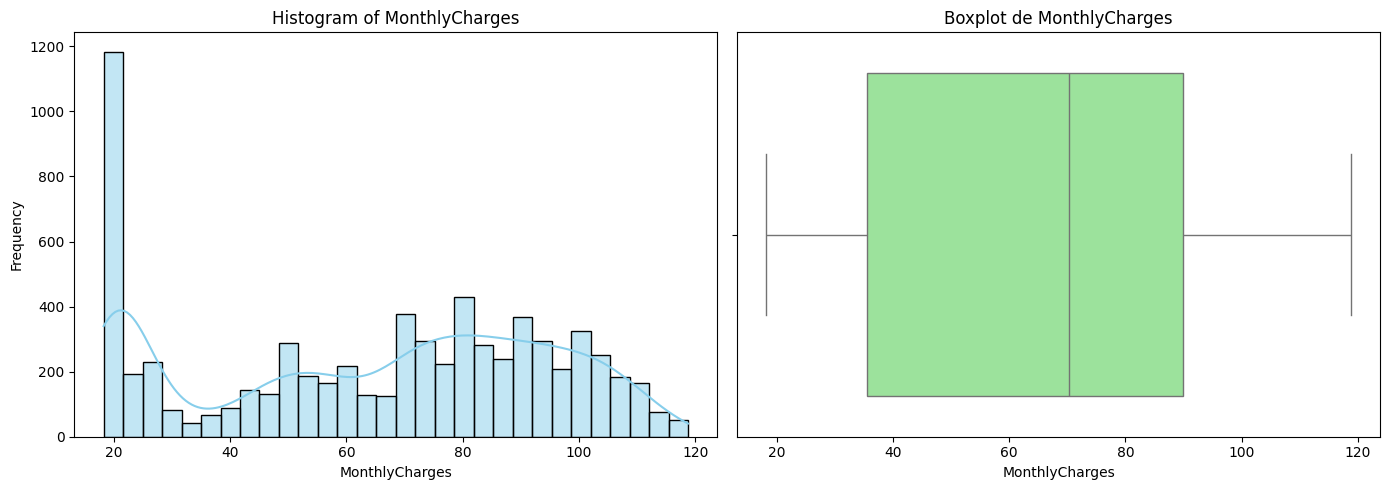

In [11]:
analyze_numeric_variables(data, coluna_numerica='MonthlyCharges')

**Histogram of MonthlyCharges:**

- Distribution skewed to the right (i.e., positive distribution): The largest concentration of customers pay lower amounts, around 20 to 30 monetary units, with a tail extending to higher amounts.

- Visible peaks indicate that there are distinct groups of customers with monthly plans in specific price ranges, which may reflect different service packages offered.

**Boxplot of MonthlyCharges:**

- The median (line in the middle of the box) is between 70 and 75, indicating that half of the customers pay up to this amount.

- The box (which represents the interquartile range, i.e., from the 1st to the 3rd quartile) is quite wide, showing high dispersion in the amounts charged, indicating the possibility of a wide range of services provided.

- There are few or no visible outliers, which indicates that the extreme values ​​are not too far outside the norm.

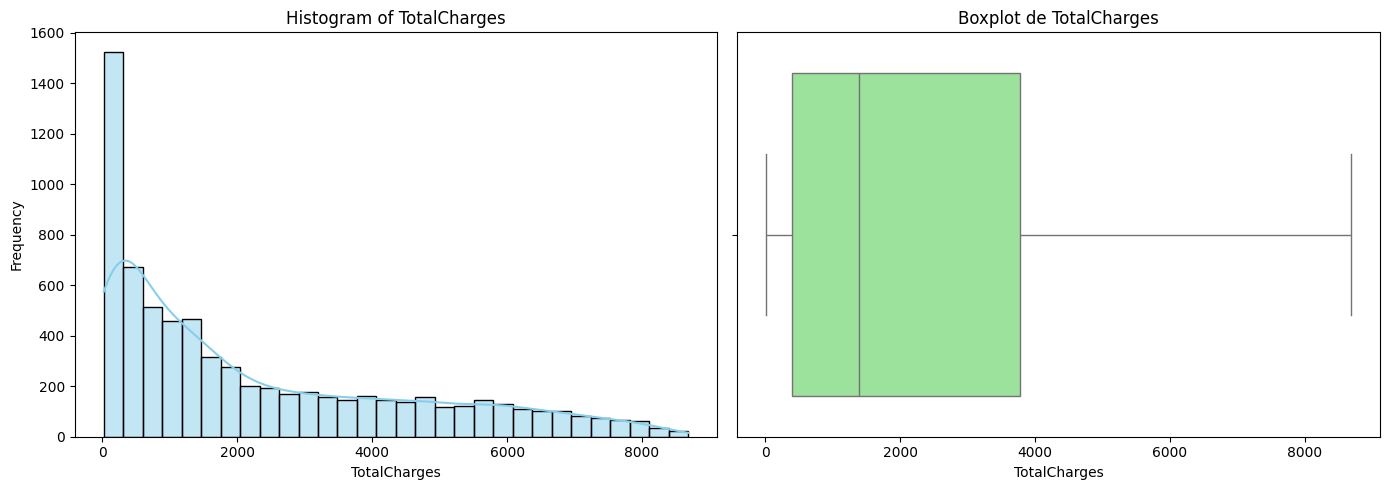

In [12]:
analyze_numeric_variables(data, coluna_numerica='TotalCharges')

**Histogram of Total Charges**:
- Highly right-skewed (positively skewed) distribution:

- Most customers have low Total Charges (total amount paid to date), below 2,000 monetary units. This may indicate that more customers are selling cheaper services.

- The long tail shows that few customers have ever paid amounts above 5,000.

**Boxplot of Total Charges**:
- Most of the data is concentrated in the interquartile range (IQR) up to about 4,000.

- There are outliers with higher amounts — customers who have been with us for a long time or on expensive plans.

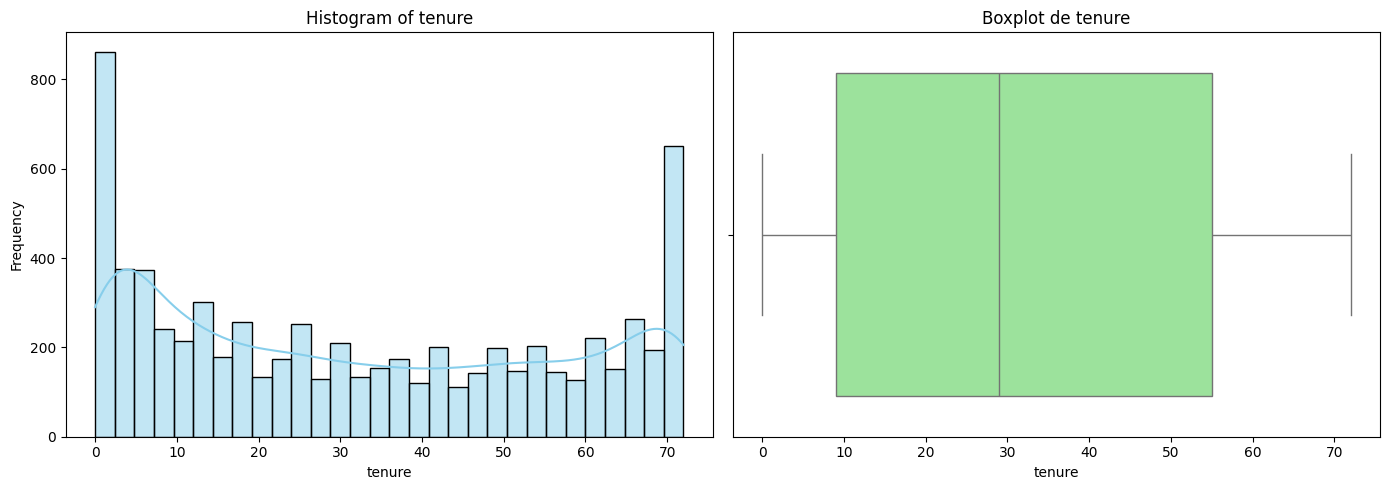

In [13]:
analyze_numeric_variables(data, coluna_numerica='tenure')

The `tenure` variable would be an indicator that represents the **length of time the customer has been with the company** in this case in months.

- If **tenure = 1**, the customer joined in the last month.

- If **tenure = 72**, the customer has been with the company for 6 years.

**Tenure Histogram**:

- High concentration of customers with very little time at the company (mainly in the first 3 months).
- There is also a peak at 72 months, indicating very loyal customers.
- Between these extremes, the distribution is well spread out, but with less frequency in the middle (customers with 20 to 50 months are less common).

**Boxplot**:
- The median is around 30 months.

- The distribution is relatively balanced, but with a slight asymmetry to the left, since there are more customers with little time.

### **2.2. Categorical Variables**

In [14]:
def analyze_frequency(df, column, top_n=None, figsize=(10, 5), palette="viridis"):
    """
    Displays the frequency of unique values ​​in a column and plots a bar chart with the values ​​at the top.

    Parameters:
    - df: DataFrame
    - column: name of the column to analyze
    - top_n: number of most frequent categories to display (None = all)
    - figsize: size of the figure
    - palette: seaborn's color palette  
    """
    # Check if column exists
    if column not in df.columns:
        print(f"Columns '{column}' not found in DataFrame.")
        return
    
    # Frequency of values
    freq = df[column].value_counts().sort_values(ascending=False)

   # Show table
    print(f"\nFrequency of unique values ​​in the column '{column}':\n")
    display(freq.head(top_n) if top_n else freq)

    # Data for the chart
    x = freq.head(top_n).index if top_n else freq.index
    y = freq.head(top_n).values if top_n else freq.values

    # Plot
    plt.figure(figsize=figsize)
    ax = sns.barplot(x=x, y=y, palette=palette)
    plt.title(f"Frequency of unique values ​​in '{column}'")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)

    # Add the values ​​at the top of the bars
    for i, value in enumerate(y):
        ax.text(i, value + max(y)*0.01, str(value), ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()


Frequency of unique values ​​in the column 'gender':



gender
Male      3555
Female    3488
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_5492\1328625825.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


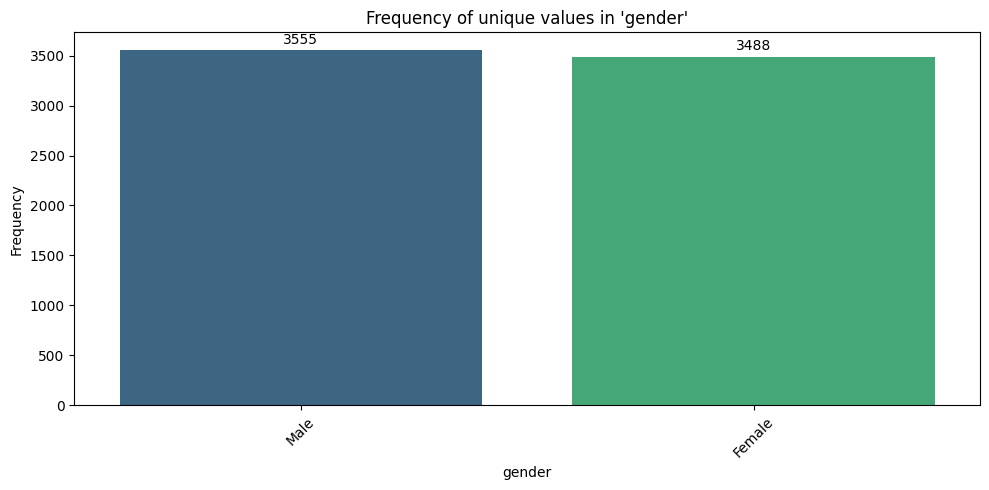

In [15]:
# Analyze frequency of 'Contract' column
analyze_frequency(data, 'gender')

- The gender distribution is quite balanced in the dataset.

- There are 3,555 male customers (50.5%) and 3,488 female customers (49.5%).

- This indicates that there is no significant gender bias in the dataset, which is important to avoid distortions during model training.


Frequency of unique values ​​in the column 'SeniorCitizen':



SeniorCitizen
0    5901
1    1142
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_5492\1328625825.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


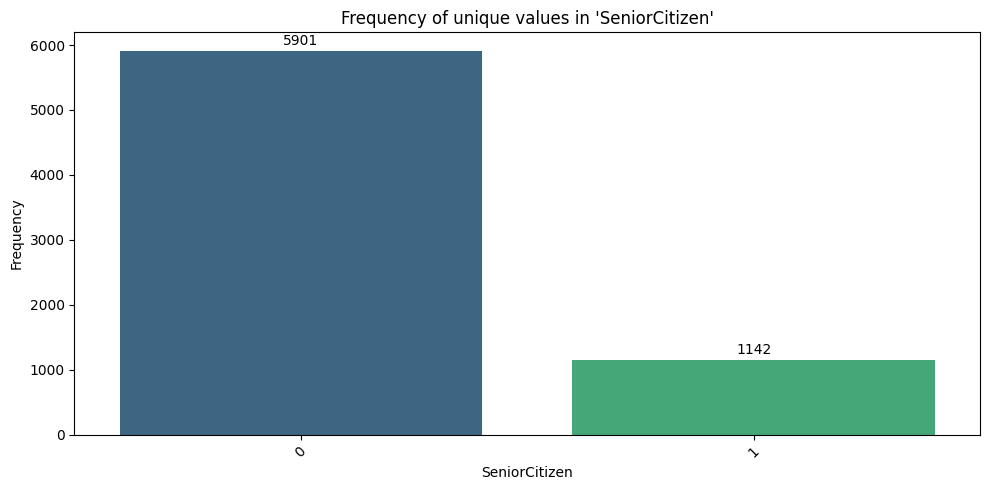

In [16]:
analyze_frequency(data, 'SeniorCitizen')

- There is a strong imbalance in the distribution of this variable.

- Approximately 84% of customers (5,901) are not seniors (`SeniorCitizen = 0`), while only 16% (1,142) are considered seniors (`SeniorCitizen = 1`).

- This imbalance may impact the model's ability to learn patterns relevant to the smaller group (seniors), especially if the variable is related to churn.

- Therefore, it is important to check whether senior customers have different churn rates, and consider balancing techniques (such as oversampling or stratified sampling) if necessary.


Frequency of unique values ​​in the column 'Partner':



Partner
No     3641
Yes    3402
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_5492\1328625825.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


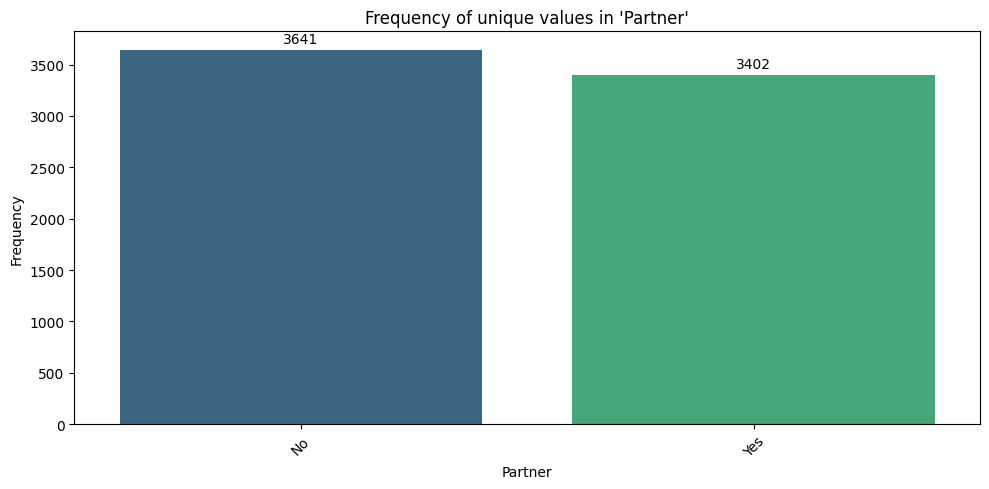

In [17]:
analyze_frequency(data, 'Partner')

- The distribution between customers with and without a partner is relatively balanced, but with a slight predominance of customers without a partner.

- 51.7% of customers (3,641) do not have a partner (`Partner = No`), while 48.3% (3,402) do (`Partner = Yes`).

- This slight imbalance should not negatively impact the model, but it is interesting to analyze whether the presence of a partner influences the retention or cancellation of the service (Churn).


Frequency of unique values ​​in the column 'Dependents':



Dependents
No     4933
Yes    2110
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_5492\1328625825.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


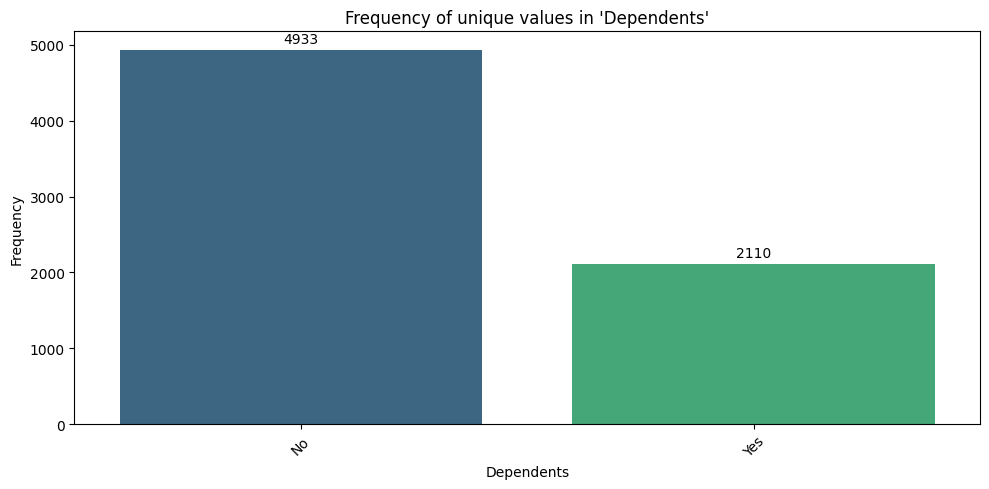

In [18]:
analyze_frequency(data, 'Dependents')

- The distribution reveals a strong imbalance:

- 70.1% of customers (4,933) do not have dependents (`Dependents = No`),

- while only 29.9% (2,110) have dependents (`Dependents = Yes`).

- This may indicate that the customer base is mostly composed of people without children or financial dependents — possibly singles or couples without children. It is important to check whether the presence of dependents is associated with cancellation behavior (Churn). Customers with dependents may demonstrate greater stability and commitment to contracted services, which may influence the cancellation rate.


Frequency of unique values ​​in the column 'PhoneService':



PhoneService
Yes    6361
No      682
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_5492\1328625825.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


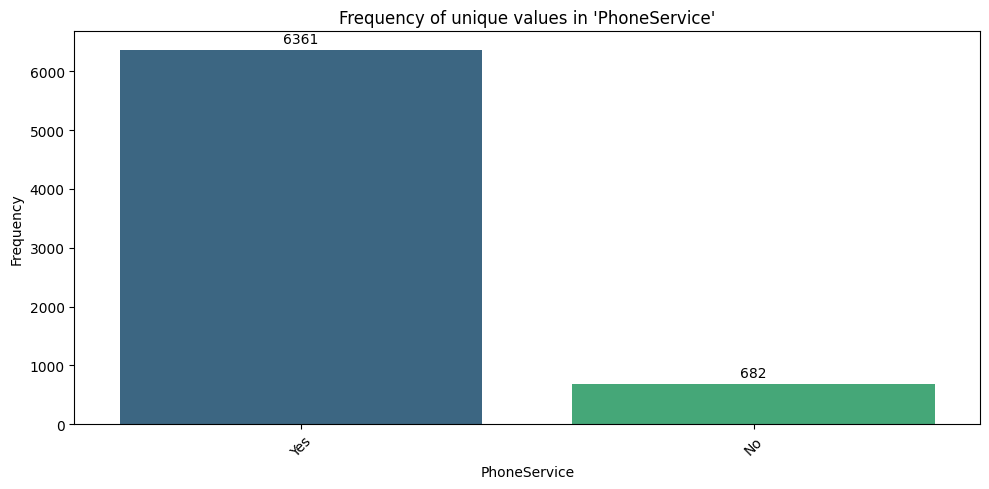

In [19]:
analyze_frequency(data, 'PhoneService')

- The distribution shows a strong imbalance between customers who have telephone service and those who do not:

- 90.3% of customers (6,361) have `PhoneService = Yes`;

- Only 9.7% (682) do not have this service.

- This pattern may indicate that telephone service is **almost a standard in the packages contracted** by the customer base, functioning as a base service to which other products can be added (such as internet, streaming or technical support).

- From the point of view of churn, it may be interesting to investigate:

- Whether customers without `PhoneService` are more or less likely to cancel;

- Whether telephone service contributes to greater loyalty when included in packages.


Frequency of unique values ​​in the column 'MultipleLines':



MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_5492\1328625825.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


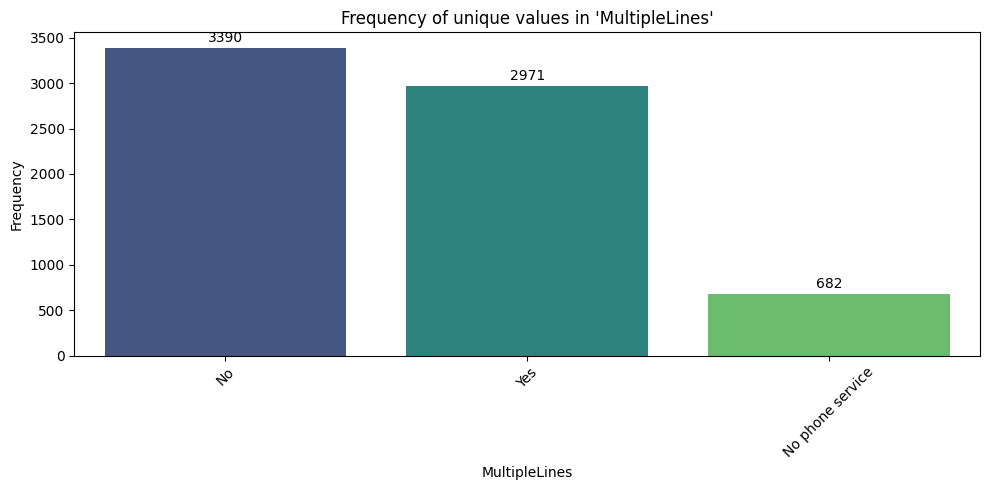

In [20]:
analyze_frequency(data, 'MultipleLines')

- Most customers have a single line (3,390) versus multiple lines (2,971). In addition, there is a significant group that does not have phone service (682).

- Customers with multiple lines are usually larger homes or businesses and, in general, may have a higher revenue value.

- Customers with a single line may be more sensitive to price or service — potentially more prone to churn.

- The graph above may indicate that the company tends to serve more customers who request only one line as a service.

- It is worth deepening the analysis of the churn rate by category to validate whether the feature strongly impacts the risk of cancellation.


Frequency of unique values ​​in the column 'InternetService':



InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_5492\1328625825.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


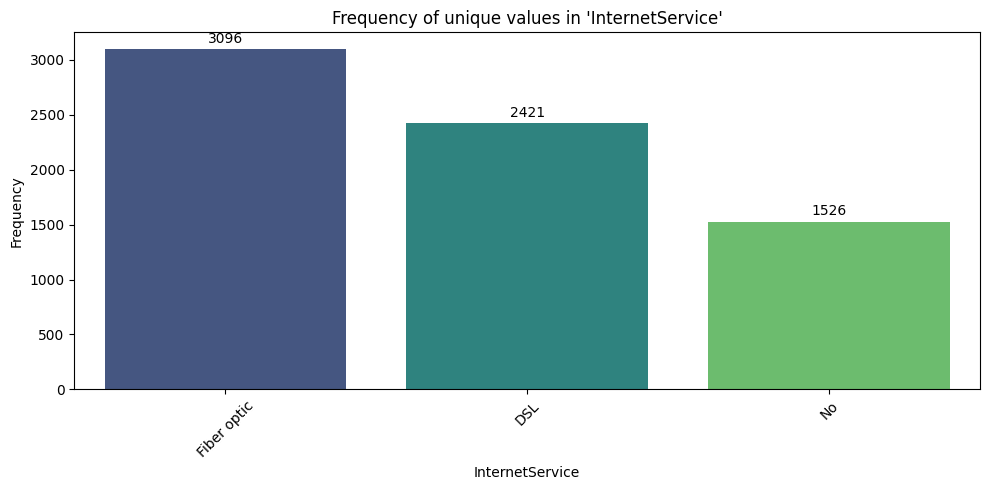

In [21]:
analyze_frequency(data, 'InternetService')

- Most customers use fiber optic (3096), followed by DSL (2421) and then customers who do not have internet service (1526).

- In this context, it is worth analyzing whether customers with fiber optics have higher or lower churn rates, because although it is the most modern service, the cost can also be higher when compared to the competition.

- Assess whether customers with DSL are more likely to cancel due to technical problems or dissatisfaction with speed.

- For customers without internet, retention strategies can focus on other services.

- For building the model:

- The `InternetService` variable can be highly relevant, as it indicates the type of service contracted, which has a direct impact on satisfaction and, consequently, on churn.

- In this case, it is worth calculating the churn rate for each category to understand the behavior of the groups.

- Check whether there are interactions of this variable with others, such as monthly price, contract, additional services.


Frequency of unique values ​​in the column 'OnlineSecurity':



OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_5492\1328625825.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


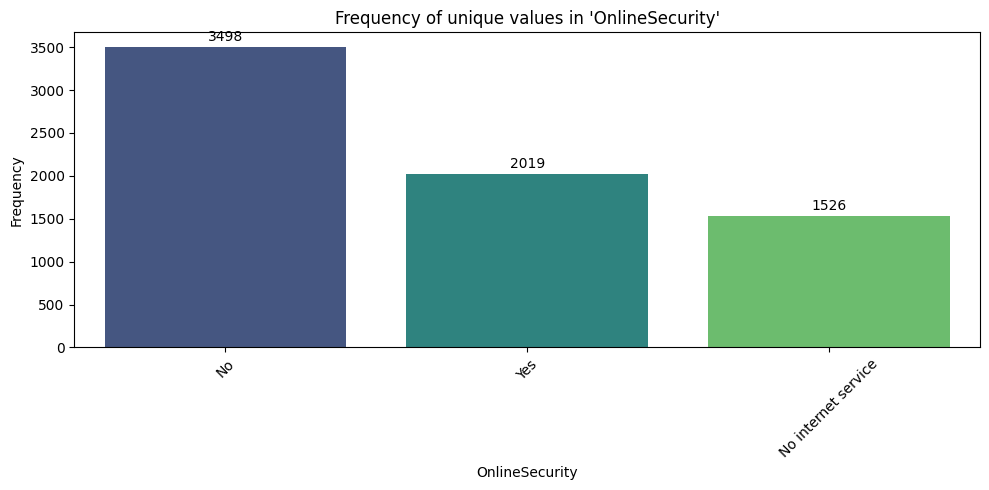

In [22]:
analyze_frequency(data, 'OnlineSecurity')

- The high number of customers who do not use the online security service, even among those who have internet access, may indicate:

- The customer does not perceive the value of this service.

- Problems in the company's communication or service offering.

- Price sensitivity, especially if the service is charged separately.

- This may be an opportunity for upselling campaigns focused on digital security, especially in a scenario where cyber threats are increasingly common.

- It is also important to check whether the absence of this service is correlated with churn, that is:

- Check whether customers without online security are more likely to cancel. If so, offering this service as a benefit in retention strategies may be effective.


Frequency of unique values ​​in the column 'OnlineBackup':



OnlineBackup
No                     3088
Yes                    2429
No internet service    1526
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_5492\1328625825.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


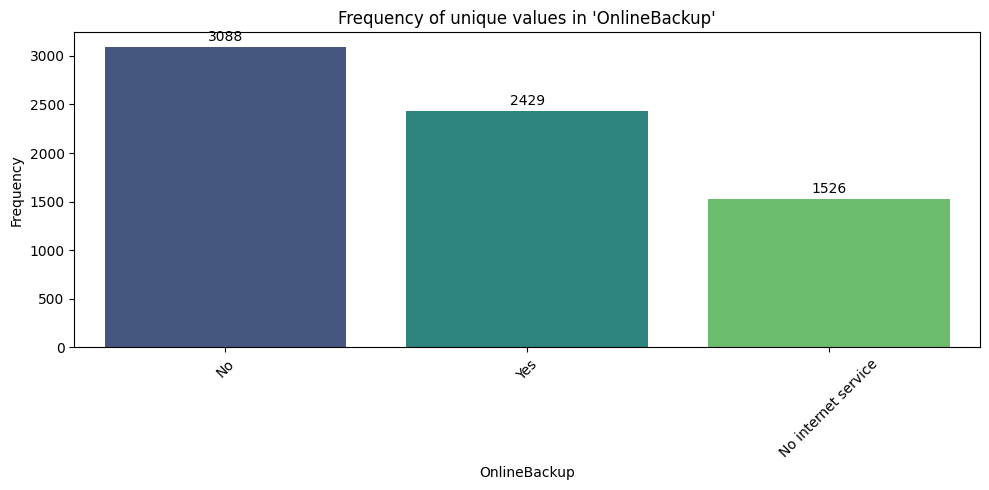

In [23]:
analyze_frequency(data, 'OnlineBackup')

- Analysis of the `OnlineBackup` variable shows that a significant portion of customers with internet access have not contracted the online backup service, while a smaller portion uses the service regularly. Another 1,526 customers do not have internet access and are therefore ineligible for the service.

- From a strategic point of view, this variable can indicate the level of customer engagement with the digital services offered by the company. If customers who use the service are less likely to churn, this functionality can be used as a loyalty element. Therefore, it is worth including this variable in the predictive modeling and investigating its relationship with service cancellation.


Frequency of unique values ​​in the column 'DeviceProtection':



DeviceProtection
No                     3095
Yes                    2422
No internet service    1526
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_5492\1328625825.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


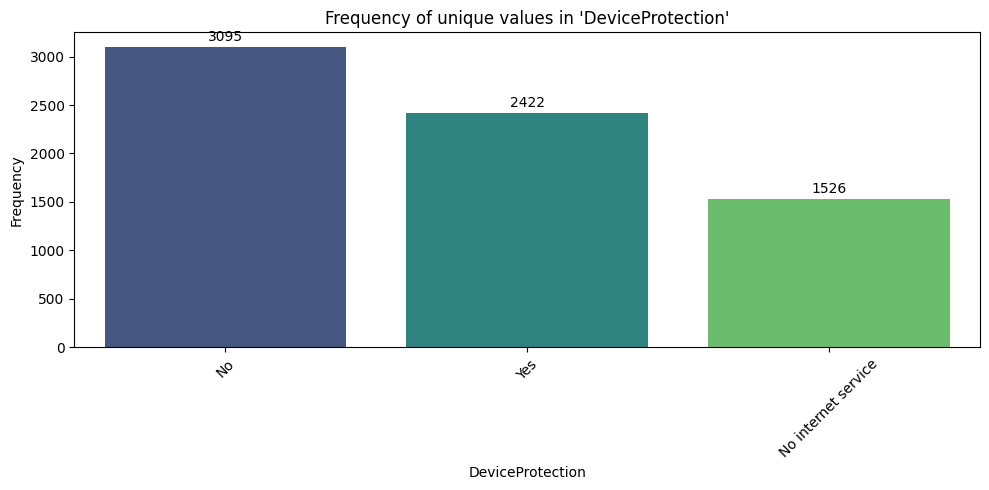

In [24]:
analyze_frequency(data, 'DeviceProtection')

- The `DeviceProtection` variable shows that most customers with internet access chose not to purchase the device protection service, while a considerable portion made use of this benefit. Another 1,526 customers did not have internet access and were therefore not eligible for the service.

- This pattern may indicate a low perception of value or low attractiveness of the service, which represents an opportunity for commercial and loyalty-building actions. If the use of the service is associated with lower churn rates, the `DeviceProtection` offer could be used as a preventive retention strategy. Therefore, this variable should be maintained in predictive modeling, as it may represent an important indicator of customer behavior.


Frequency of unique values ​​in the column 'TechSupport':



TechSupport
No                     3473
Yes                    2044
No internet service    1526
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_5492\1328625825.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


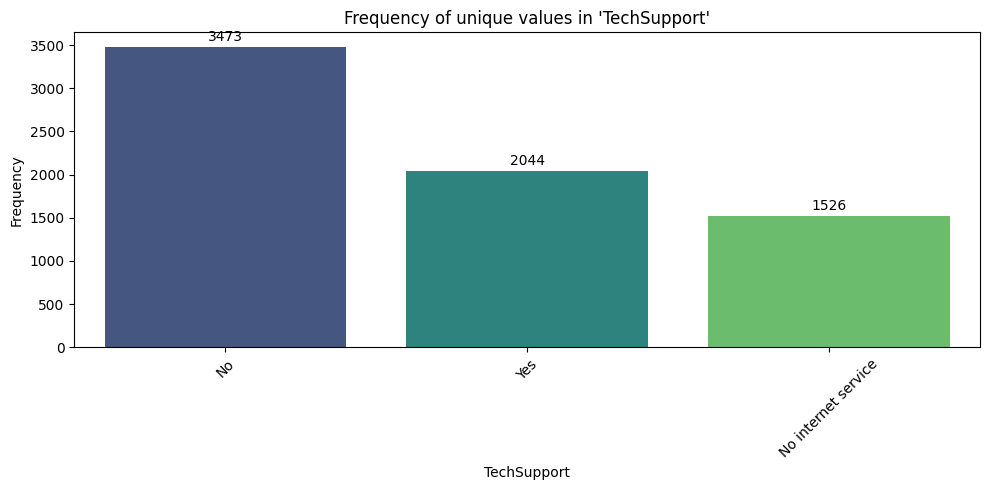

In [25]:
analyze_frequency(data, 'TechSupport')

- The `TechSupport` variable shows that most customers with internet access have not contracted the technical support service. 2,044 customers use it regularly, while 1,526 customers do not have internet service and are therefore not eligible for support.

- From a strategic point of view, the technical support service can be an important differentiator in the customer experience, especially at critical moments. If a lower churn rate is observed among customers who use this service, it can be positioned as a retention tool or included in personalized offers. Therefore, it is recommended that the variable be considered in predictive modeling as a possible indicator of engagement and loyalty.


Frequency of unique values ​​in the column 'StreamingTV':



StreamingTV
No                     2810
Yes                    2707
No internet service    1526
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_5492\1328625825.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


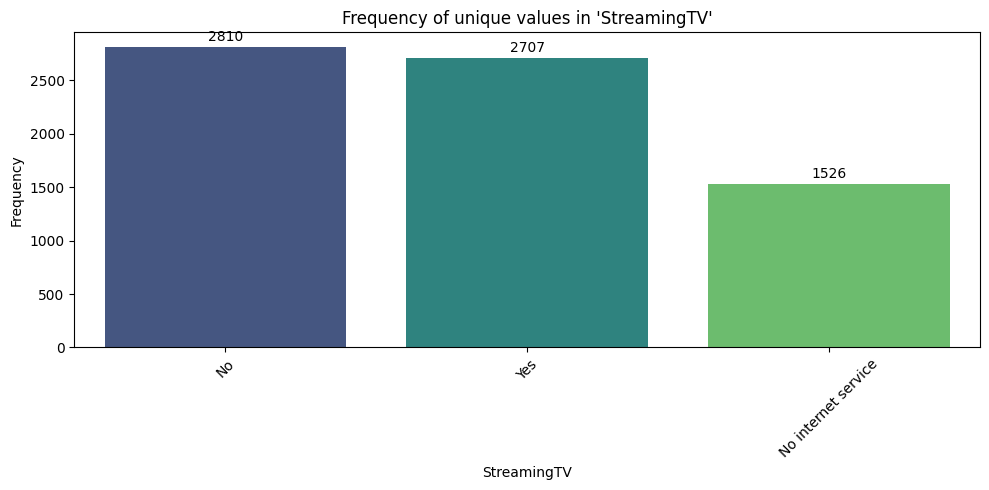

In [26]:
analyze_frequency(data, 'StreamingTV')

- The `StreamingTV` variable presents a balanced distribution between customers who have subscribed to the service (2,707) and those who have chosen not to subscribe (2,810), among those with internet access. Another 1,526 customers do not have internet service and therefore do not have access to the streaming TV service.

- This balanced distribution may indicate that the service is well accepted in the market, but there is still room for growth. If subscribing to the service is associated with a lower propensity for churn, its offer can be positioned as a strategic benefit for customer retention. Therefore, it is recommended to include `StreamingTV` in the predictive modeling as a potentially relevant variable to identify the level of customer engagement.


Frequency of unique values ​​in the column 'StreamingMovies':



StreamingMovies
No                     2785
Yes                    2732
No internet service    1526
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_5492\1328625825.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


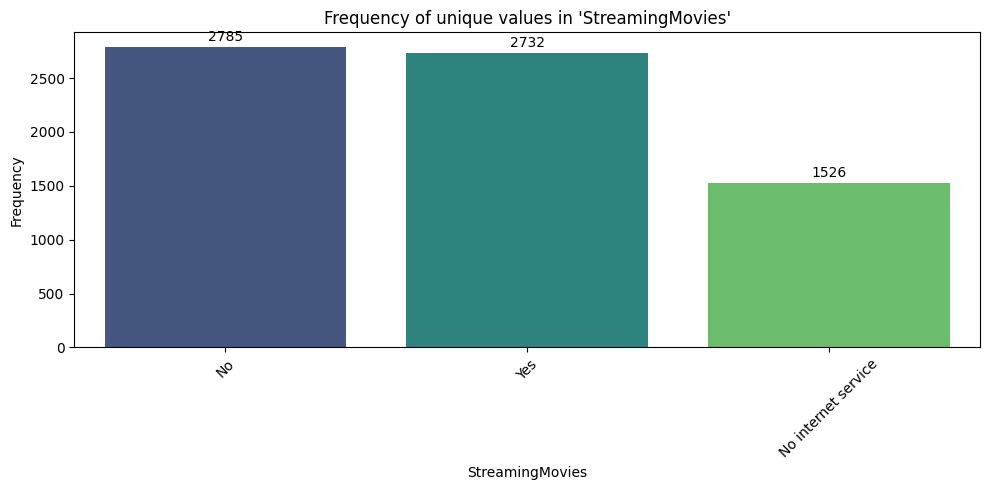

In [27]:
analyze_frequency(data, 'StreamingMovies')

- The `StreamingMovies` variable shows an almost balanced division among customers with internet: 2,732 have subscribed to the service and 2,785 have not. Another 1,526 customers do not have internet access, making them ineligible for the service.

- This parity suggests that the movie service is well accepted among users, but there is still potential for growth. If it is confirmed that customers who use this type of service are less likely to churn, it can be explored as a loyalty tool, including through combined packages.

- Therefore, `StreamingMovies` should be considered a relevant variable for predictive modeling, since it can reflect the level of engagement and propensity for customer retention.


Frequency of unique values ​​in the column 'Contract':



Contract
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_5492\1328625825.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


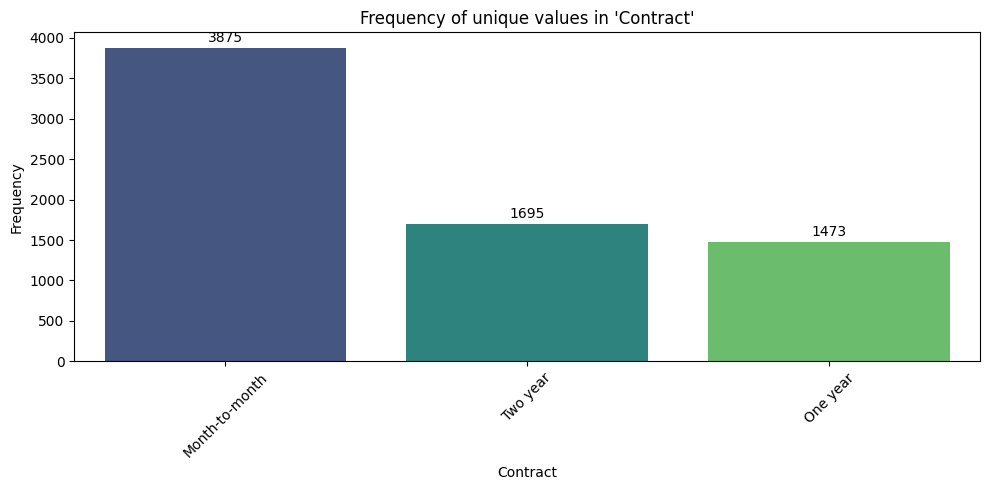

In [28]:
analyze_frequency(data, 'Contract')

- The `Contract` variable reveals that more than 60% of customers are on the `Month-to-month` plan, that is, without a long-term contractual relationship. This indicates a highly volatile base, with a higher risk of cancellation. The `One-year` and `Two-year` contracts represent a smaller share, but tend to be more stable and committed.

- Given that monthly plans generally have higher churn rates, this variable can be critical for both predictive modeling and retention actions. Initiatives that encourage migration to longer contracts can help stabilize the base and reduce revenue losses. Therefore, `Contract` should be considered one of the most relevant variables for predicting churn, and can also be used as a basis for targeted loyalty campaigns.


Frequency of unique values ​​in the column 'PaperlessBilling':



PaperlessBilling
Yes    4171
No     2872
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_5492\1328625825.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


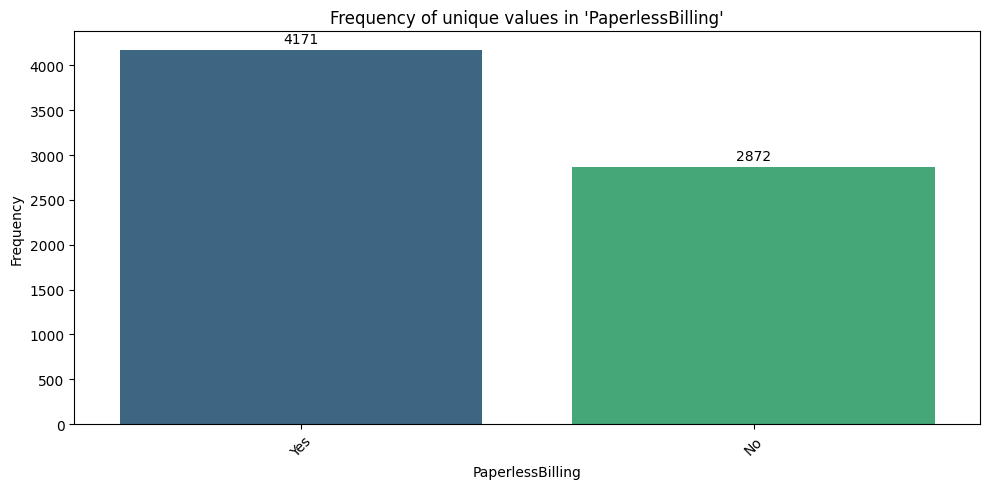

In [29]:
analyze_frequency(data, 'PaperlessBilling')

- Most customers (around 59%) opted for digital billing (`PaperlessBilling = Yes`), which may indicate greater familiarity with online channels and a preference for convenience.

- However, in many cases, this profile is also associated with a higher risk of churn, especially when combined with monthly contracts (given the ease of canceling the service). Customers with `PaperlessBilling = No` may represent a more conservative but more stable base. Therefore, this variable should be considered in predictive modeling, as it can help capture different levels of customer engagement and behavior regarding the company's services.


Frequency of unique values ​​in the column 'PaymentMethod':



PaymentMethod
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_5492\1328625825.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


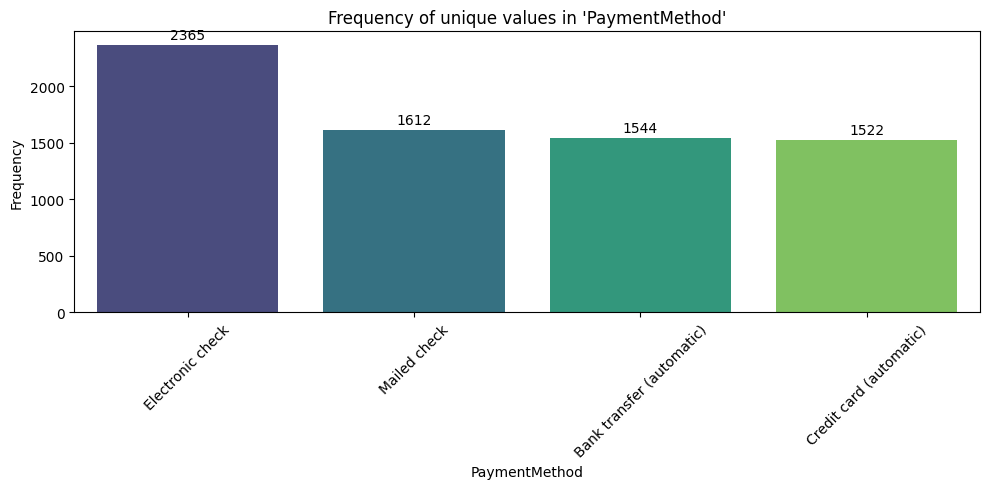

In [30]:
analyze_frequency(data, 'PaymentMethod')

- The `PaymentMethod` variable reveals important differences in customer profiles. The most common method is `Electronic check`, followed by `Mailed check`, while automatic methods (`Bank transfer` and `Credit card`) are less used.

- Automatic methods are often associated with **more stable customers and less likely to churn**, as they involve less recurring effort. On the other hand, customers who use `Electronic check` tend to have a **higher risk of cancellation**, possibly because they are more susceptible to payment difficulties or lower engagement.

- Therefore, this variable may have a strong predictive value and may contribute to strategies that encourage migration to automatic methods, as a way to increase retention.


Frequency of unique values ​​in the column 'Churn':



Churn
No     5174
Yes    1869
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_5492\1328625825.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


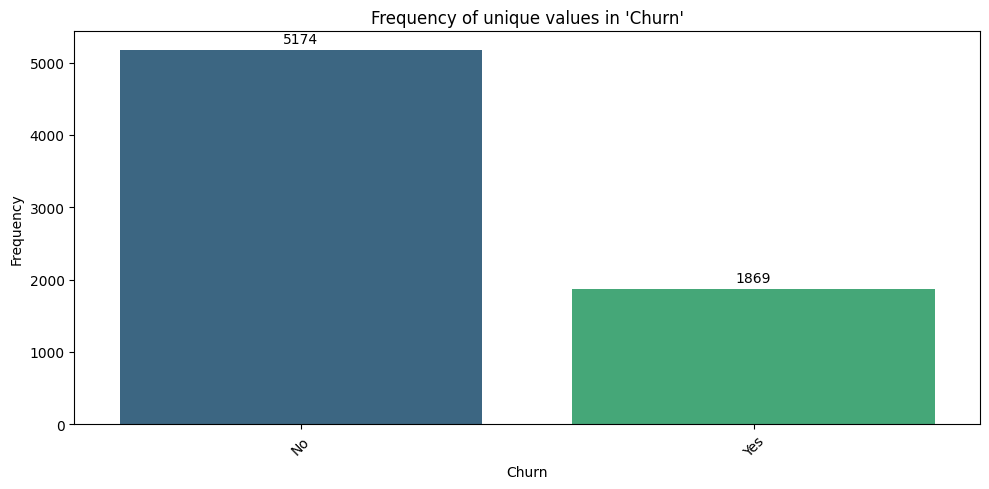

In [31]:
analyze_frequency(data, 'Churn')

- The `Churn` variable, which represents service cancellation, shows that **approximately 26.5% of customers canceled the service**. This is a significant rate that highlights the importance of preventive actions and retention strategies. From a modeling perspective, this variable presents a certain **class imbalance**, which requires special care in the choice of modeling techniques and evaluation metrics, to ensure that the model can correctly identify customers at risk, even if they are a minority.

## **🔄 3. Bivariate Analysis**

### **3.1. Categorical variables vs Churn**

The aim of this step is to explore and visualize the relationship between categorical variables and customer churn. This will help us identify whether certain categories — such as gender, geographic location, or contract type — are more strongly associated with churn, and provide valuable insights for subsequent modeling and decision-making.

In [32]:
def plot_categorical_churn_with_counts(df, categorical_vars, target='Churn', positive_class='Yes', ncols=2, figsize_per_plot=(8,5)):
    nplots = len(categorical_vars)
    nrows = (nplots + ncols - 1) // ncols
    
    plt.figure(figsize=(figsize_per_plot[0]*ncols, figsize_per_plot[1]*nrows))
    
    for i, cat_var in enumerate(categorical_vars, 1):
        plt.subplot(nrows, ncols, i)
        
        # Group to count total and calculate churn rate
        grouped = df.groupby(cat_var)
        counts = grouped.size()
        churn_rate = grouped[target].apply(lambda x: (x == positive_class).mean())
        
        # Create dataframe to plot
        plot_df = pd.DataFrame({'count': counts, 'churn_rate': churn_rate})
        plot_df = plot_df.sort_values('churn_rate', ascending=False).reset_index()
        
        # Plot bars for counting
        ax1 = plt.gca()
        sns.barplot(x=cat_var, y='count', data=plot_df, color='lightgray', ax=ax1)
        ax1.set_ylabel('Number of Customers', color='gray')
        ax1.set_xlabel(cat_var)
        ax1.tick_params(axis='x', rotation=45)
        
        # Add numbers on top of the bars
        for idx, row in plot_df.iterrows():
            ax1.text(idx, row['count'] + max(plot_df['count'])*0.01, f"{row['count']}", 
                     ha='center', va='bottom', color='black', fontsize=9)
        
        # Create secondary axis for churn rate
        ax2 = ax1.twinx()
        sns.pointplot(x=cat_var, y='churn_rate', data=plot_df, color='red', ax=ax2)
        ax2.set_ylabel('Churn Rate (%)', color='red')
        ax2.set_ylim(0, 1)
        ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.1f}%'))
        
        # Add numbers next to line points
        for idx, row in plot_df.iterrows():
            ax2.text(idx, row['churn_rate'] + 0.03, f"{row['churn_rate']*100:.1f}%", 
                     ha='center', va='bottom', color='red', fontsize=9)
        
        plt.title(f'{cat_var} - Number of Customers and Churn Rate')
    
    plt.tight_layout()
    plt.show()


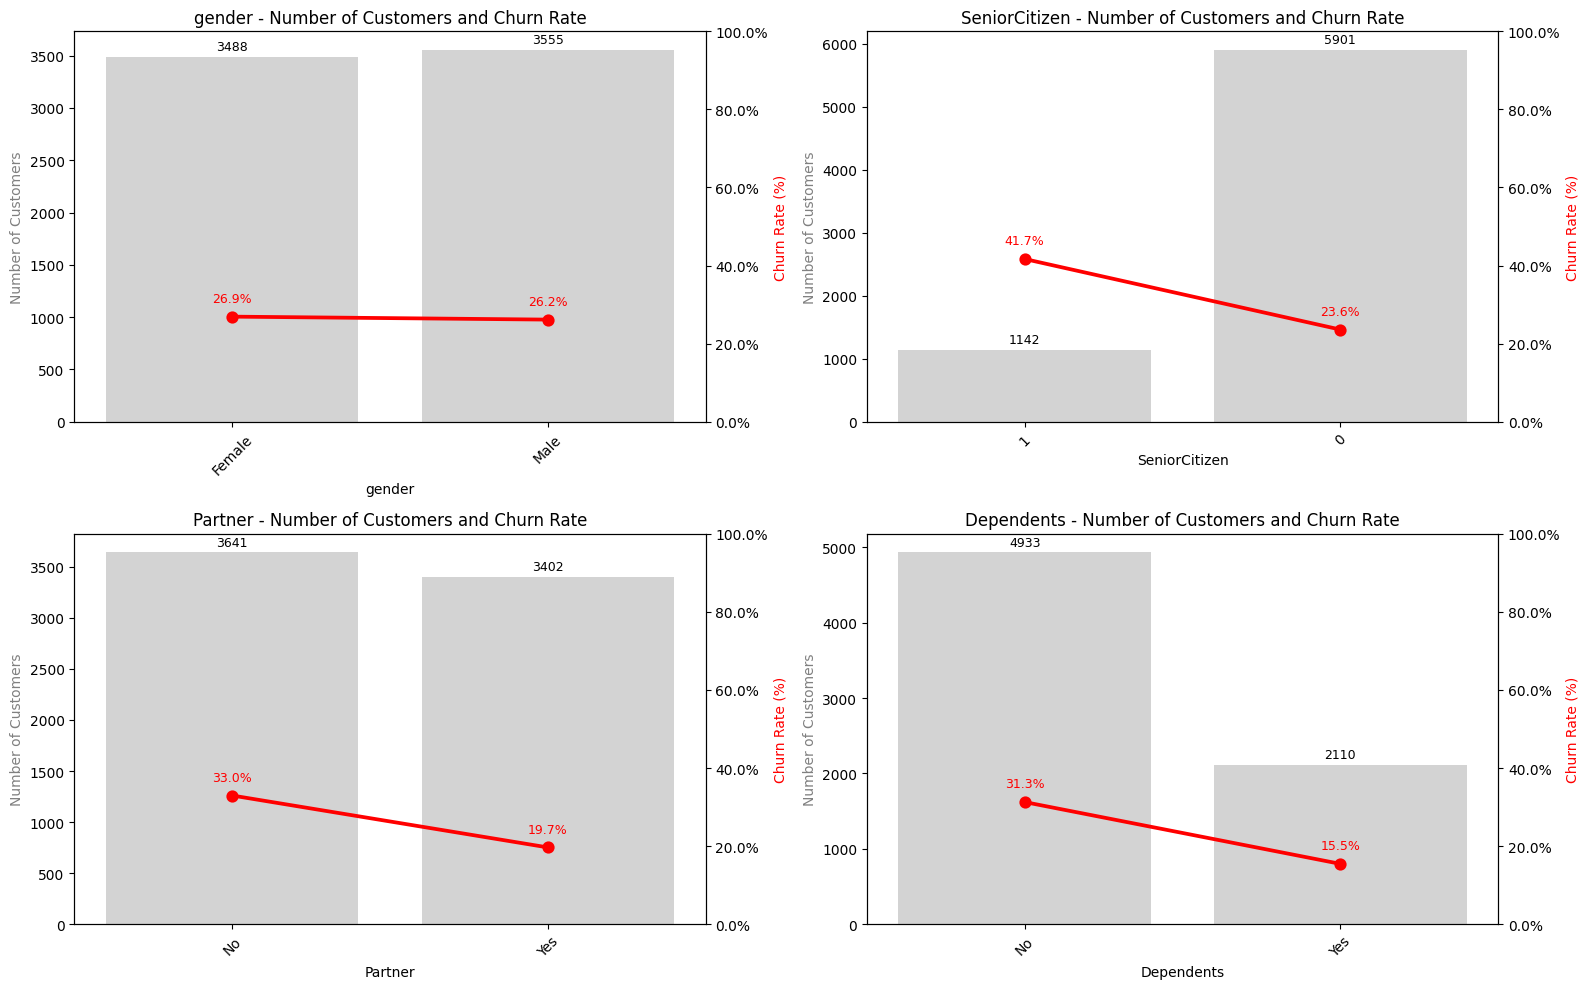

In [33]:
categorical_vars = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']
plot_categorical_churn_with_counts(data, categorical_vars)


**Gender:**
- There is no significant difference in churn rate between genders. Therefore, gender does not appear to be a good predictor of churn.

**SeniorCitizen**
- Senior customers are **almost twice as likely to cancel**. `SeniorCitizen` appears to have a strong correlation with churn and should be considered in any model.

**Partner**
- Having a partner is **associated with lower churn**. Possibly, customers with partners have more stability or ties to the service.

**Dependents**
- Customers with dependents are **less likely to cancel** the service, perhaps because they depend more on stability. This variable may also be important for the model
    

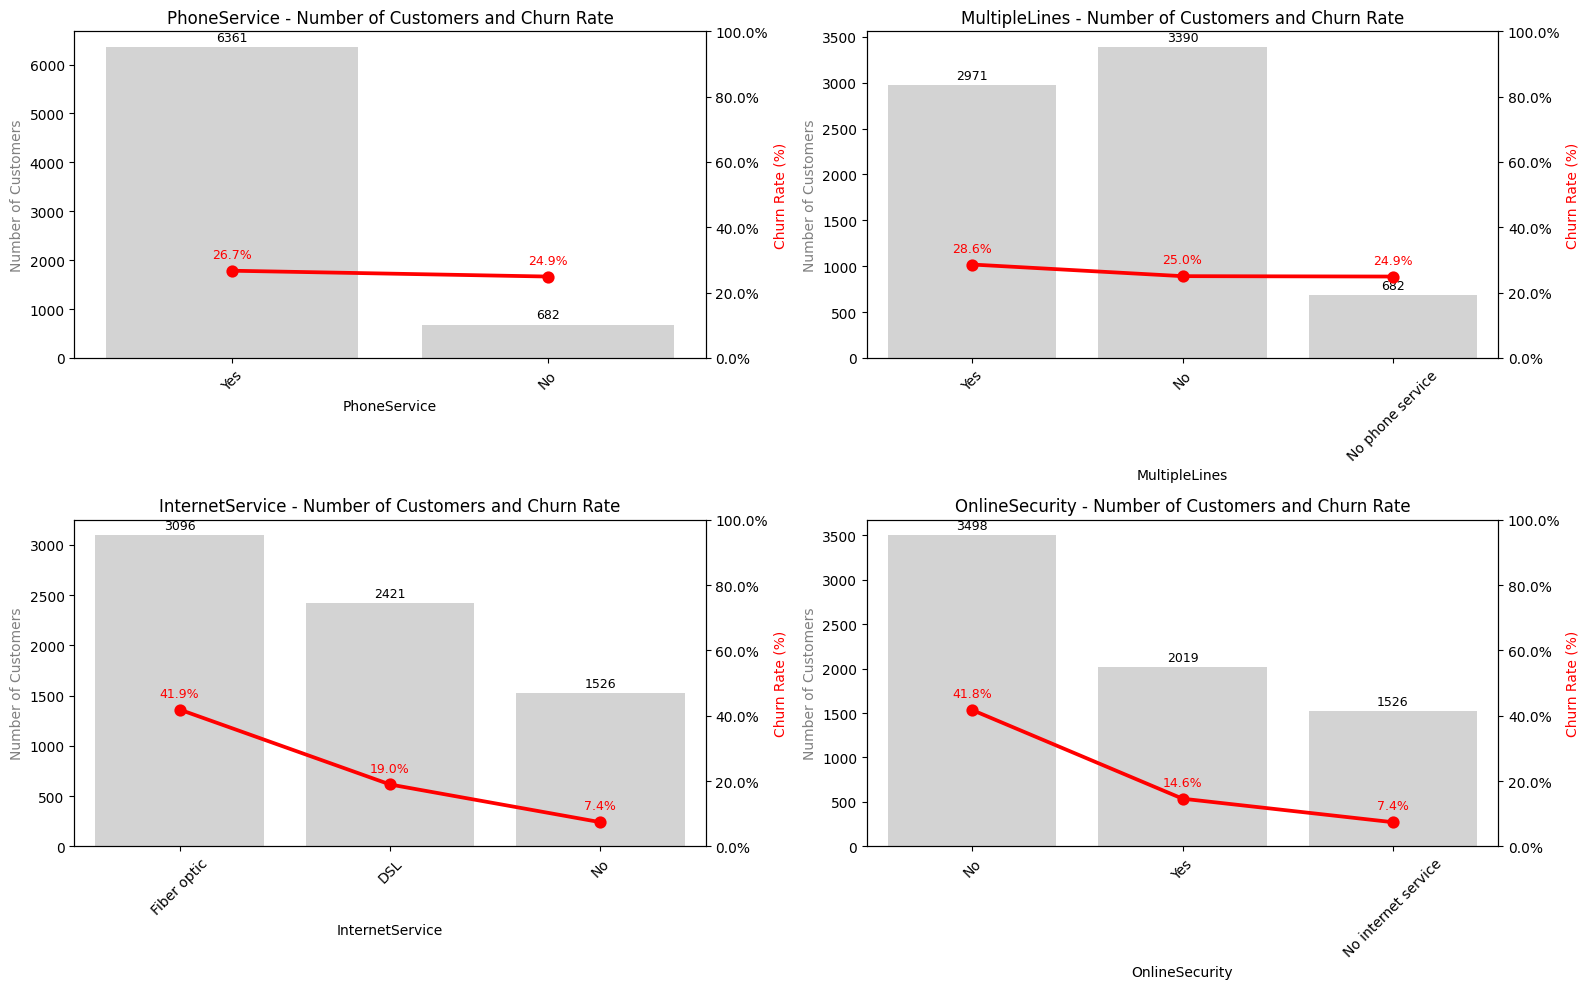

In [34]:
categorical_vars = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity']
plot_categorical_churn_with_counts(data, categorical_vars)

**PhoneService**

- The churn rate is **slightly higher** for those who have telephone service. However, the difference is small.

**MultipleLines**

- Having multiple lines is **slightly associated** with a higher churn rate. However, the difference is not that significant.

**InternetService**

- Customers with **fiber optics have a very high churn rate**, much higher than those who use DSL. Those who **do not have internet rarely cancel**, which may be because they are not already engaged with the service.

**OnlineSecurity**

- Customers **without online security** have a much higher churn rate. This shows that **not purchasing additional security services** may be linked to dissatisfaction.

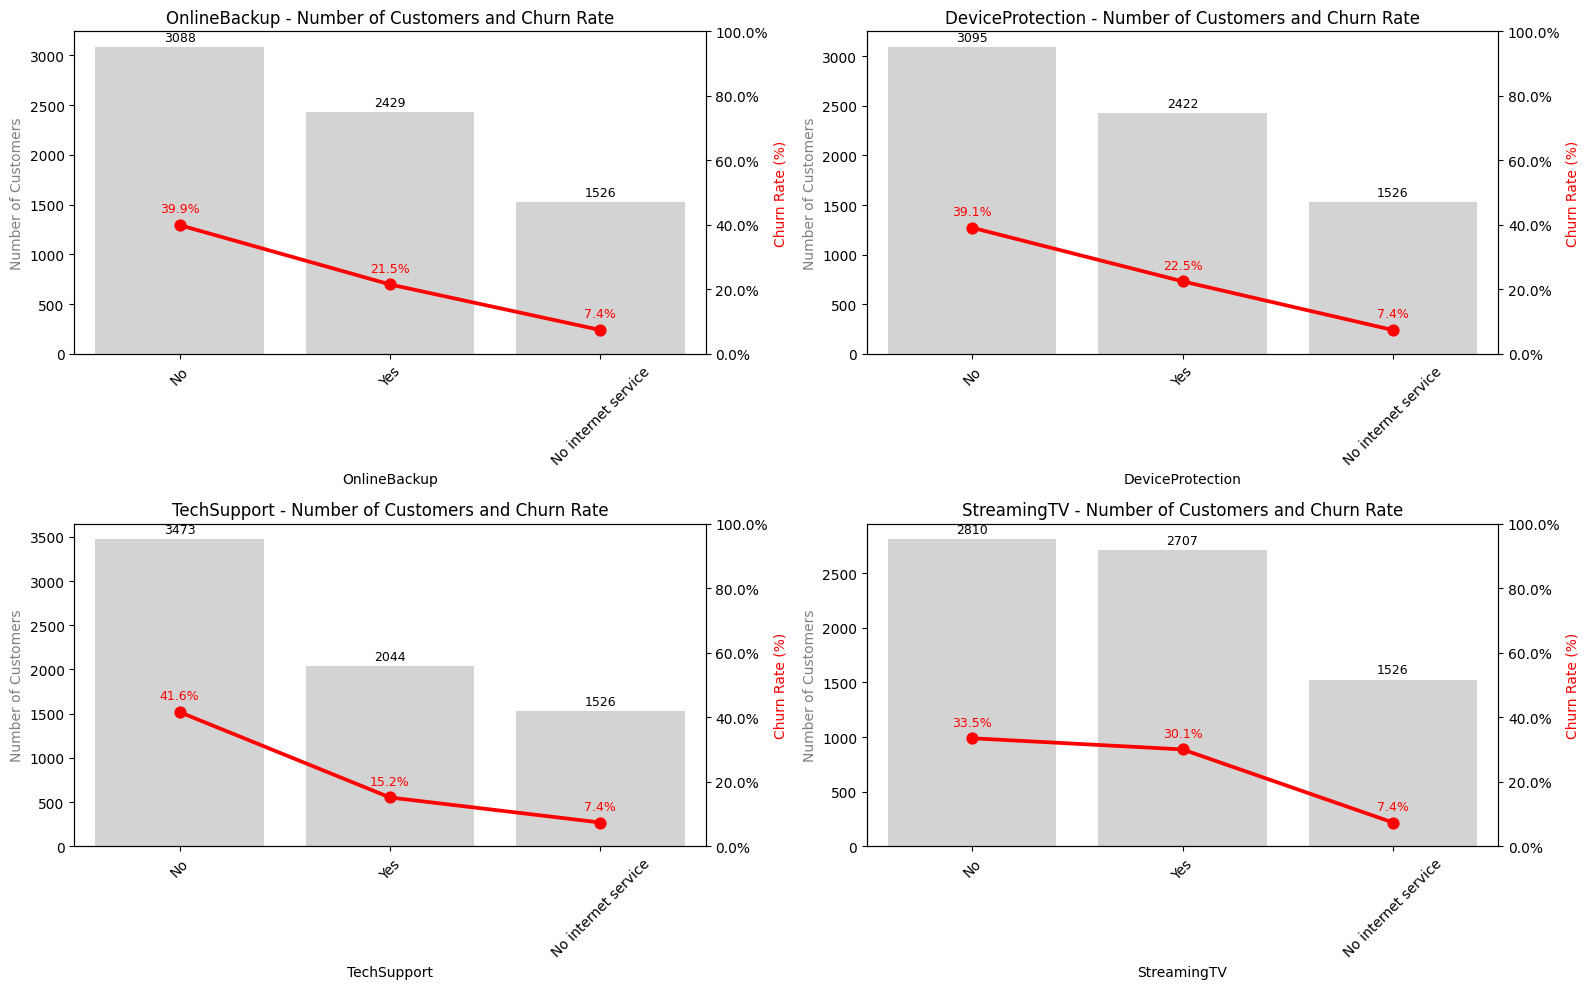

In [35]:
categorical_vars = ['OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV']
plot_categorical_churn_with_counts(data, categorical_vars)

**OnlineBackup**
- Customers who **don't have online backup** have **almost double** the churn rate compared to those who do.

**DeviceProtection**
- Once again, the **lack of additional services** such as device protection is related to higher churn.

**TechSupport**
- This is one of the biggest contrasts between yes and no. Those who have technical support stay much longer. **Very high impact** → TechSupport is a very strong predictor of churn.

Strategies that increase the use or perceived value of support can reduce churn drastically.

**StreamingTV**
- The difference between yes and no is **small**, but it exists. Churn is **slightly higher for those who don't use StreamingTV**.

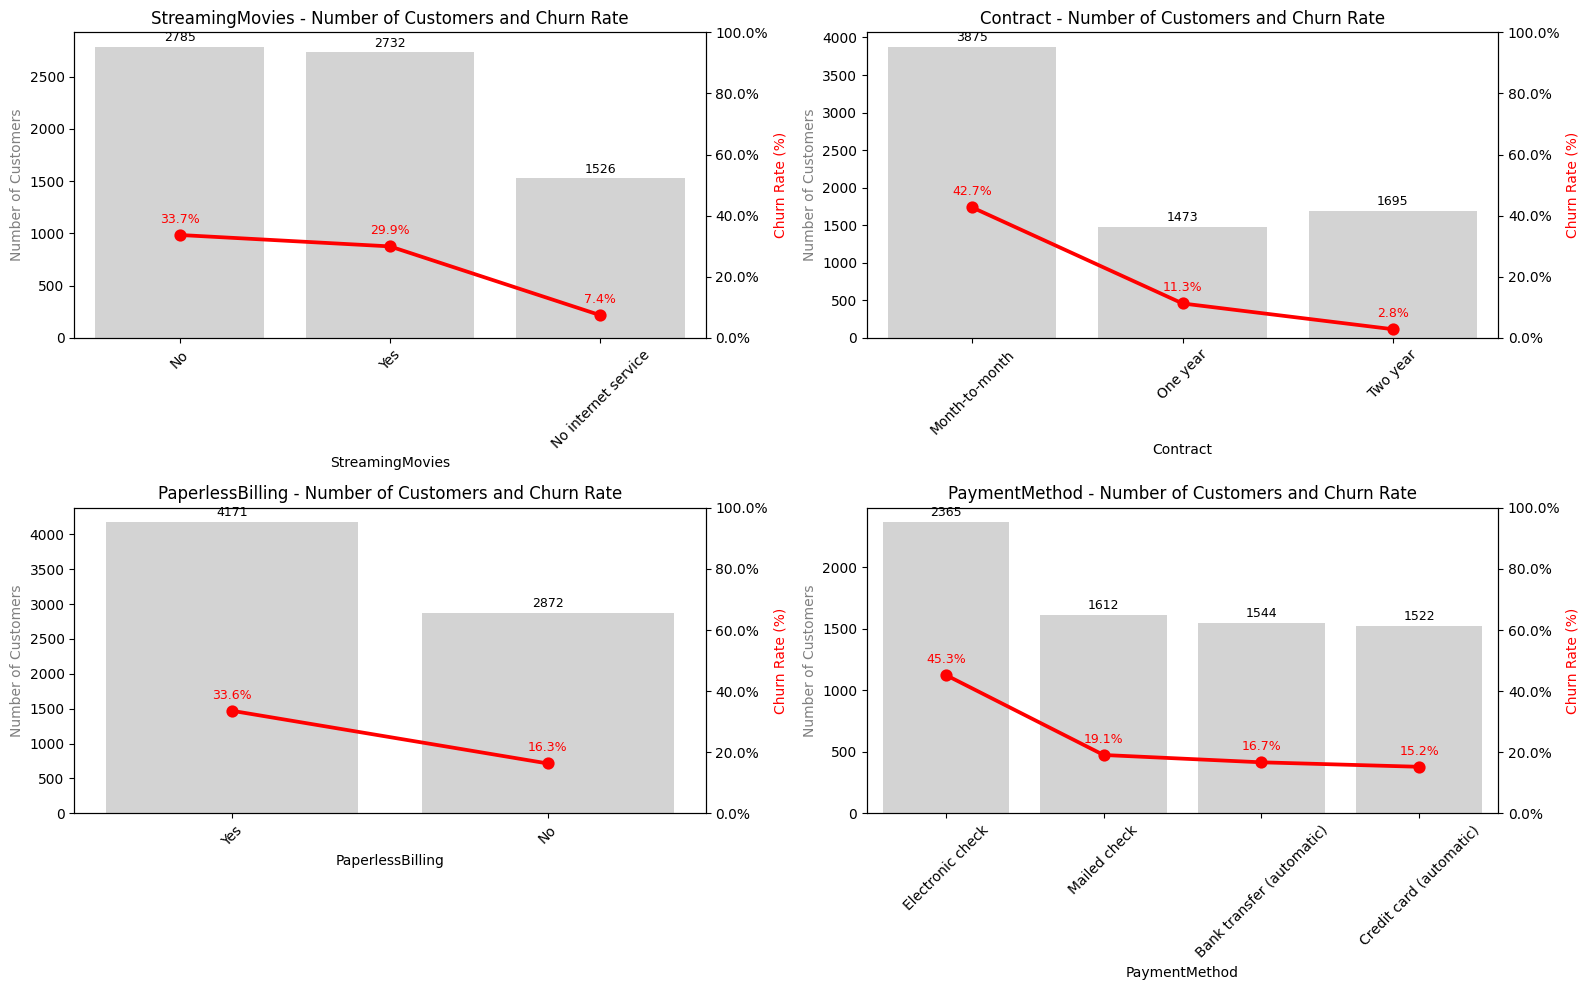

In [36]:
categorical_vars = ['StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
plot_categorical_churn_with_counts(data, categorical_vars)

**StreamingMovies**
- The difference between customers who use and do not use StreamingMovies is small (around 4%).

**Contract**
- Customers with longer contracts **churn much less**.

**PaperlessBilling**
- Users with `PaperlessBilling` have **double the churn rate**. This may indicate a more digital profile, which switches services more easily.

**PaymentMethod**
- Automatic payments (card and transfer) have lower churn. `Electronic` check has the **highest churn rate**.

### **3.2. Numeric variables vs Churn**

In [37]:
def plot_numeric_vs_target(data, feature, target='Churn', figsize=(12, 6)):
    """
    Generates boxplot and violin plot for a specific numeric variable vs target variable.

    Parameters:
    - data: Pandas DataFrame
    - feature: Name of numeric variable to be analyzed
    - target: Name of target variable (default = 'Churn')
    - figsize: Size of graphs (default = (12, 6))
    """
    # Validation
    if feature not in data.columns:
        raise ValueError(f"The column'{feature}' does not exist in the DataFrame.")
    
    if not pd.api.types.is_numeric_dtype(data[feature]):
        raise TypeError(f"The column '{feature}' is not numeric.")

    plt.figure(figsize=figsize)

    # Boxplot with hue=target to avoid FutureWarning
    plt.subplot(1, 2, 1)
    sns.boxplot(x=target, y=feature, data=data, hue=target, palette="Set2", legend=False)
    plt.title(f'Boxplot: {feature} vs {target}')

    # Violin plot with hue=target to avoid FutureWarning
    plt.subplot(1, 2, 2)
    sns.violinplot(x=target, y=feature, data=data, hue=target, palette="Set2", legend=False)
    plt.title(f'Violin Plot: {feature} vs {target}')
    
    plt.tight_layout()
    plt.show()


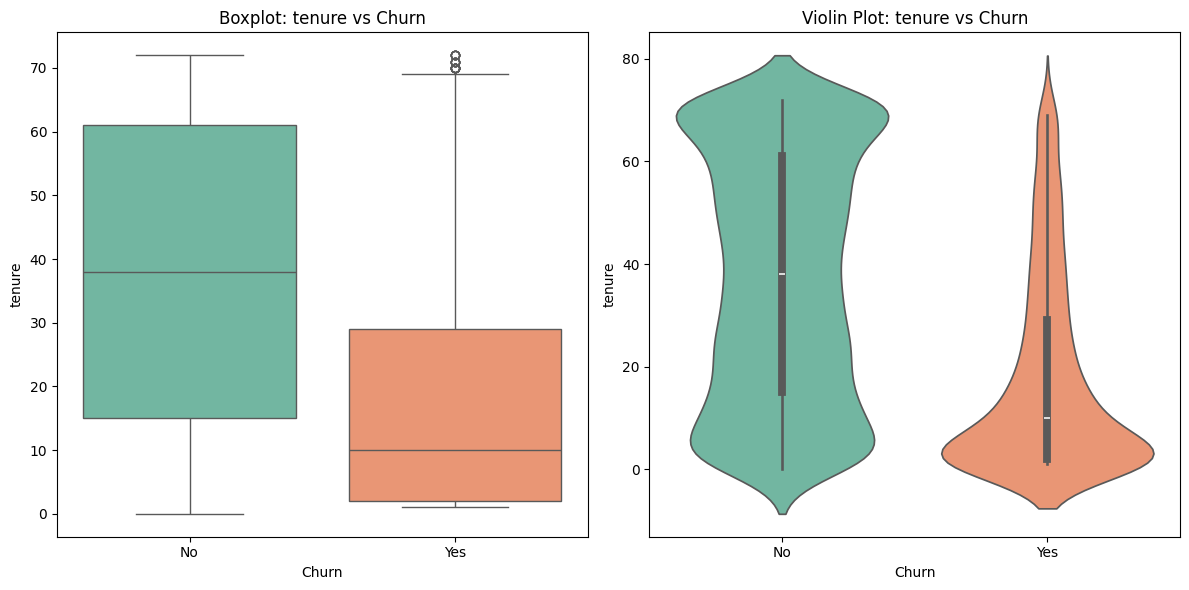

In [38]:
plot_numeric_vs_target(data, 'tenure')

**1. Customers who did NOT leave (`Churn = No`):**
- They have a much wider tenure distribution.

- The median is high (around 38 months).

- There are many customers with tenure between 20 and 70 months.

- Few outliers.

**2. Customers who left (`Churn = Yes`):**
- Most have a low tenure (median around 10 months).

- The distribution is concentrated in the first months of use.

- The right tail shows that some stayed for a long time, but they are a minority.

- There are several outliers for higher tenure values.

**Conclusion**

- Customers with **longer tenure** are less likely to cancel.

- Churn occurs mainly in the first months of the relationship.

- This suggests that working on early retention strategies **may be effective** to reduce churn.

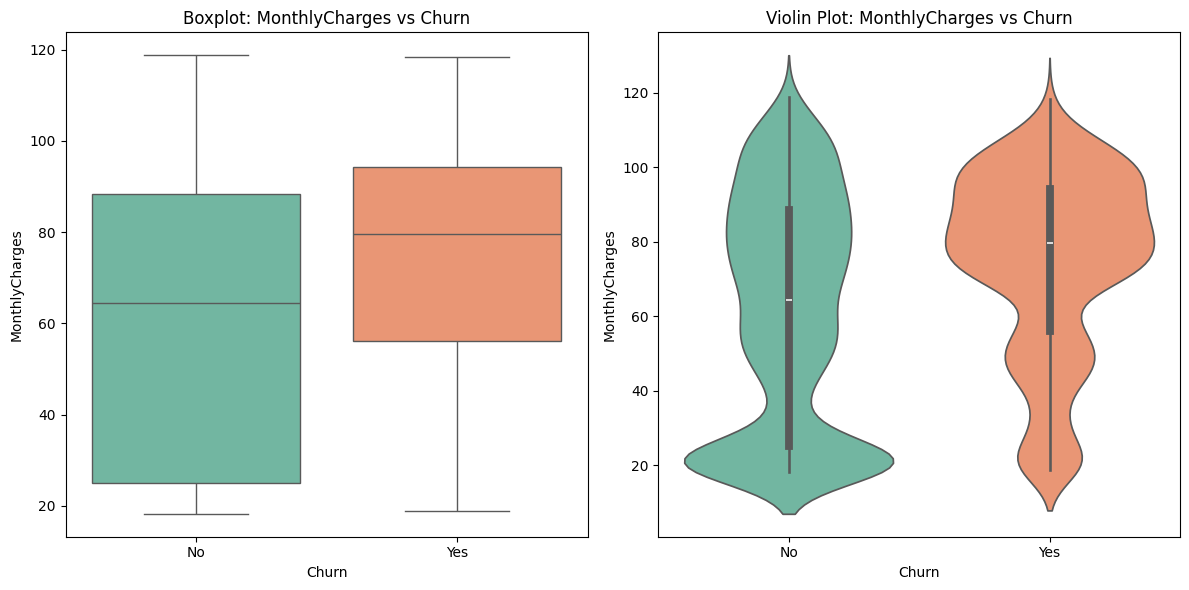

In [39]:
plot_numeric_vs_target(data, 'MonthlyCharges')

**1. Customers who did NOT churn (`Churn = No`):**

- Monthly spending shows greater variability, with many customers paying low to medium amounts.

- Median is below 70.

- More spread out distribution with high density at low amounts (as seen in the wider lower part of the violin plot).

**2. Customers who churned (`Churn = Yes`):**

- Customers who canceled have a higher median spending (close to 80).

- Density is concentrated at higher monthly billing amounts (wider violin plot between 70–100).

- Suggests that customers with higher bills tend to cancel more frequently.

**Conclusion**

- Customers who pay more monthly are more likely to churn.

- Possibly, more expensive plans are not meeting expectations, or causing dissatisfaction.

- Strategies such as better alignment of perceived value with cost or offers for expensive plans can help with retention.

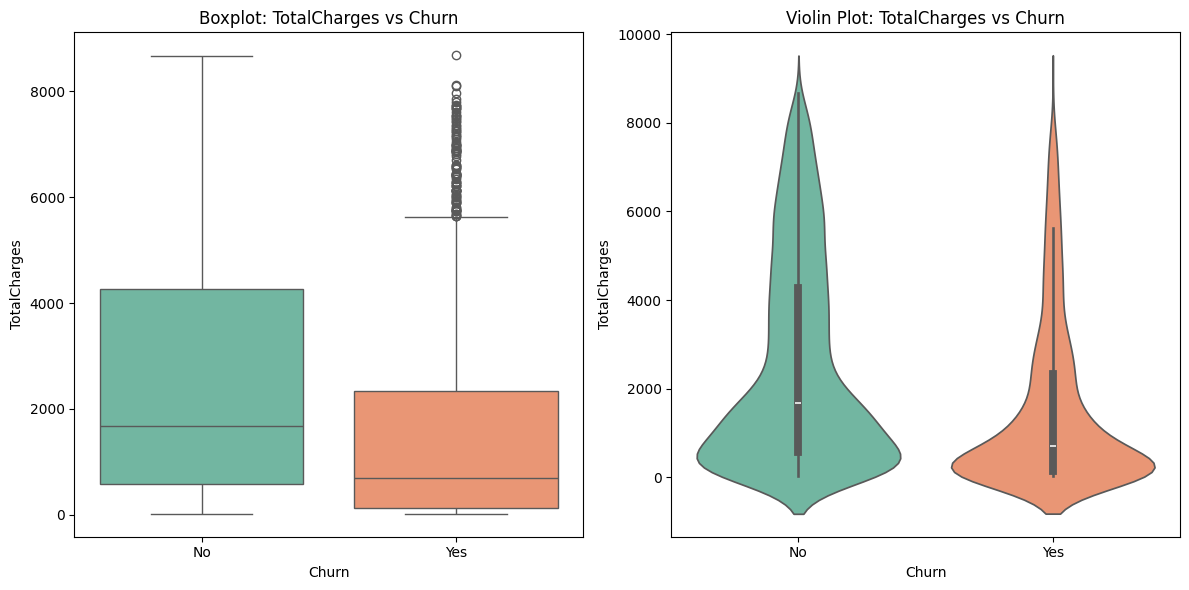

In [40]:
plot_numeric_vs_target(data, 'TotalCharges')

**1. Customers who did NOT churn (`Churn = No`):**

- `TotalCharges` for these customers tend to be higher compared to those who churned.

- The median of total charges is significantly higher.

- The boxplot shows a wide spread, with several outliers above the median (customers who spent a lot over time).

- The violin plot reinforces the concentrated density at higher levels of `TotalCharges`, indicating that many of these customers have long tenure and accumulated charges.

- Loyal customers tend to accumulate more charges over time, as they remain with the service.

**2. Customers who left (`Churn = Yes`):**

- The median of `TotalCharges` is much lower, showing that many cancel in the first few months.

- The distribution is asymmetric, with density concentrated at low values ​​(violin plot with a wide base between 0–1000).

- The boxplot indicates less variability in the values ​​and fewer extreme outliers.

- This suggests that customers who leave tend to do so early — perhaps due to initial dissatisfaction or barriers to joining

**Insights:**

- Customers with higher TotalCharges tend to stay — indicating longer stay and possible satisfaction with the service.

- Customers who cancel have lower TotalCharges, suggesting problems in the initial experience.

- Strategies to reduce early churn are essential:

- Better onboarding

- Proactive support in the first few months

- Trial period or initial benefits

## **🔗 4. Multivariate Analysis**

### **4.1. Correlation between numerical variables**

In [41]:
def analyze_correlation(df, metodo=None, annot=True, figsize_heatmap=(10, 8), cmap='coolwarm'):
    """
    Analyzes correlation between numeric variables and generates scatter plots.

    Parameters:
    - df: Pandas DataFrame.
    - method: Correlation method ('pearson', 'spearman', 'kendall').
    - annot: Show values ​​in heatmap.
    - figsize_heatmap: Heatmap figure size.
    - figsize_scatters: Base figure size for scatter plots.
    - cmap: Colormap for heatmap.

    Returns:
    - Correlation matrix.
    """
    # Select valid numeric columns (no NaN)
    df_num = df.select_dtypes(include=['int64', 'float64']).dropna()

    if df_num.shape[1] < 2:
        print("At least two numeric variables are required.")
        return None

    # === 1. Correlation Matrix ===
    corr_matrix = df_num.corr(method=metodo)

    plt.figure(figsize=figsize_heatmap)
    sns.heatmap(corr_matrix, annot=annot, cmap=cmap, fmt=".2f", square=True, linewidths=0.5)
    plt.title(f'Correlation Matrix - Method: {metodo.capitalize()}', fontsize=14)
    plt.tight_layout()
    plt.show()

    return corr_matrix

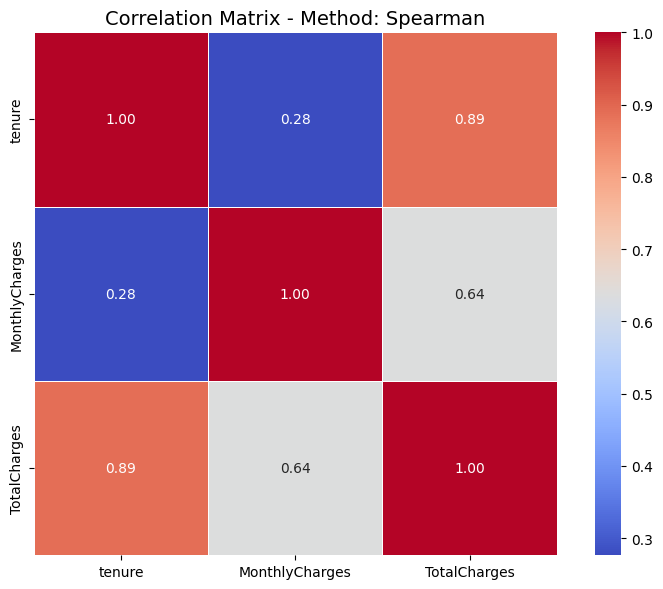

,tenure,MonthlyCharges,TotalCharges
tenure,1.000000,0.276417,0.886998
MonthlyCharges,0.276417,1.000000,0.637475
TotalCharges,0.886998,0.637475,1.000000


In [42]:
analyze_correlation(data, metodo='spearman', figsize_heatmap=(8,6))

**🔹 Correlation between tenure and TotalCharges (~0.89)**

- This was expected, because: `TotalCharges` is a cumulative variable — the longer the tenure, the higher the total charge.

**🔹 Correlation between MonthlyCharges and TotalCharges (~0.64)**

- This is also expected, because: `TotalCharges` ≈ `MonthlyCharges` × `tenure`, that is, even if `MonthlyCharges` varies, it is still one of the main components of `TotalCharges`.

**🔹 Correlation between tenure and MonthlyCharges (~0.28)**

- This relationship is weak, which also makes sense: The time the customer is in the plan (`tenure`) is not directly linked to how much he pays per month. Plans can have varying monthly values, regardless of the tenure.

### **4.2. Pair Charts**

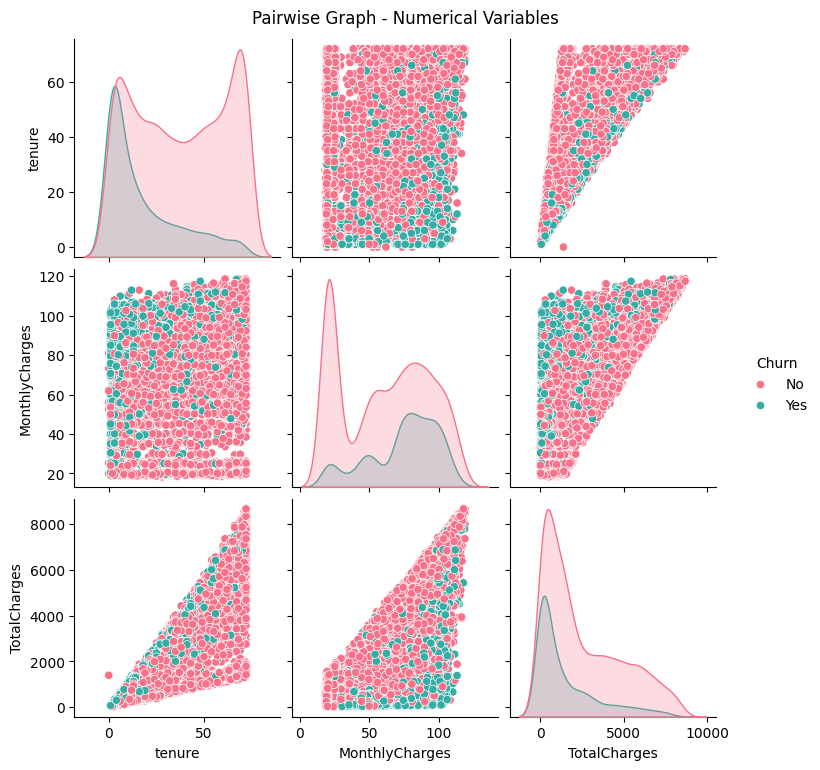

In [43]:
num_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

# If your DataFrame is called df:
sns.pairplot(data[num_features + ['Churn']], hue='Churn', palette='husl', diag_kind='kde')
plt.suptitle('Pairwise Graph - Numerical Variables', y=1.02)
plt.show()

✅ Churn is strongly associated with the short contract period (low tenure) and, consequently, the lower total amount paid by the user.

✅ The monthly fee does not have such an evident connection, being relatively distributed for both Churn and non-Churn.

This means that the customer retention model will probably benefit from focusing on strategies to engage the user in the first few months, trying to extend the contract, rather than focusing so much on the monthly fee.

## **🧹 5. Modeling Preparation**

### **5.1. Understanding the Impact of Categorical Variables via Encoding and Correlation**

Before training the Machine Learning model, it is essential to transform the categorical variables into a numerical format that the algorithms can interpret correctly. Since our initial goal is to identify the most relevant variables to predict Churn, we adopted a mixed encoding strategy with two purposes:

1. Verify linear correlations between categorical variables and the target variable using OneHotEncoder.

2. Subsequently, apply LabelEncoder to all categorical variables to feed a tree model (Random Forest), which is more sensitive to non-linear relationships and allows us to evaluate the importance of each feature in the prediction.

In [44]:
# Creating a copy of the original dataset for preprocessing for model training. 
data_model = data.copy()

In [45]:
# Removing the CustomerID column:
data_model = data_model.drop(columns=['customerID', 'gender'])

In [46]:
data_model['AvgMonthlySpend'] = data_model['TotalCharges'] / (data_model['tenure'] + 1)

# How many online services the customer does not have
data_model['NoOnlineServices'] = (
    (data_model['OnlineSecurity'] == 'No').astype(int) +
    (data_model['OnlineBackup'] == 'No').astype(int) +
    (data_model['DeviceProtection'] == 'No').astype(int) +
    (data_model['TechSupport'] == 'No').astype(int)
)

# How many entertainment services do you not have?
data_model['NoStreaming'] = (
    (data_model['StreamingTV'] == 'No').astype(int) +
    (data_model['StreamingMovies'] == 'No').astype(int)
)

# Total number of services the customer has
def count_services(row):
    count = 0
    service_cols = [
        'PhoneService', 'MultipleLines', 'InternetService',
        'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
        'TechSupport', 'StreamingTV', 'StreamingMovies'
    ]
    for col in service_cols:
        if 'No internet service' in row[col] or 'No phone service' in row[col]:
            continue
        if row[col] in ['Yes', 'Fiber optic', 'DSL']:
            count += 1
    return count

data_model['TotalServices'] = data_model.apply(count_services, axis=1)


# Churn risk (score heuristic)
data_model['RiskScore'] = ((data_model['Contract'] == 'Month-to-month').astype(int) + (data_model['OnlineSecurity'] == 'No').astype(int) +
    (data_model['TechSupport'] == 'No').astype(int) + (data_model['PaymentMethod'] == 'Electronic check').astype(int) + (data_model['tenure'] < 6).astype(int))


We initially applied a hybrid method of variable transformation, using:

- **LabelEncoder** for binary variables (e.g. `Partner`, `Churn`, `PhoneService`), where ordinal coding does not distort the meaning of the data.

- **OneHotEncoder** for variables with multiple categories (e.g. `InternetService`, `Contract`, `PaymentMethod`), ensuring that the algorithms do not assume non-existent ordinal relationships between categories.

This approach allows us to explore the correlation matrix between the coded variables and `Churn`. However, it is important to note that Pearson's correlation only measures linear relationships, which may limit interpretation in more complex cases.

In [47]:
def transform_dataframe_hibryd_method(df):
    """
   Applies LabelEncoder and OneHotEncoder to the specified columns.

    Returns a DataFrame with the transformed columns.
    """
    # Columns for LabelEncoder
    label_cols = [ 'SeniorCitizen', 'Partner', 'Dependents','PhoneService', 'PaperlessBilling', 'Churn']
    
   # Columns for OneHotEncoder
    onehot_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup','DeviceProtection', 'TechSupport', 'StreamingTV','StreamingMovies', 'Contract', 'PaymentMethod']
    
    df_transformed = df.copy()
    
    # Applying LabelEncoder
    label_encoder = LabelEncoder()
    for col in label_cols:
        df_transformed[col] = label_encoder.fit_transform(df_transformed[col])
    
    # Applying OneHotEncoder
    ohe = OneHotEncoder(sparse_output=False, drop=None)
    ohe_array = ohe.fit_transform(df_transformed[onehot_cols])
    ohe_columns = ohe.get_feature_names_out(onehot_cols)
    df_ohe = pd.DataFrame(ohe_array, columns=ohe_columns, index=df.index)
    
    # Remove original one-hot columns and add encoded ones
    df_transformed.drop(columns=onehot_cols, inplace=True)
    df_final = pd.concat([df_transformed, df_ohe], axis=1)
    
    return df_final


In [48]:
df_encoded = transform_dataframe_hibryd_method(data_model)

#Checking the dimensions: 
df_encoded.shape

(7043, 45)

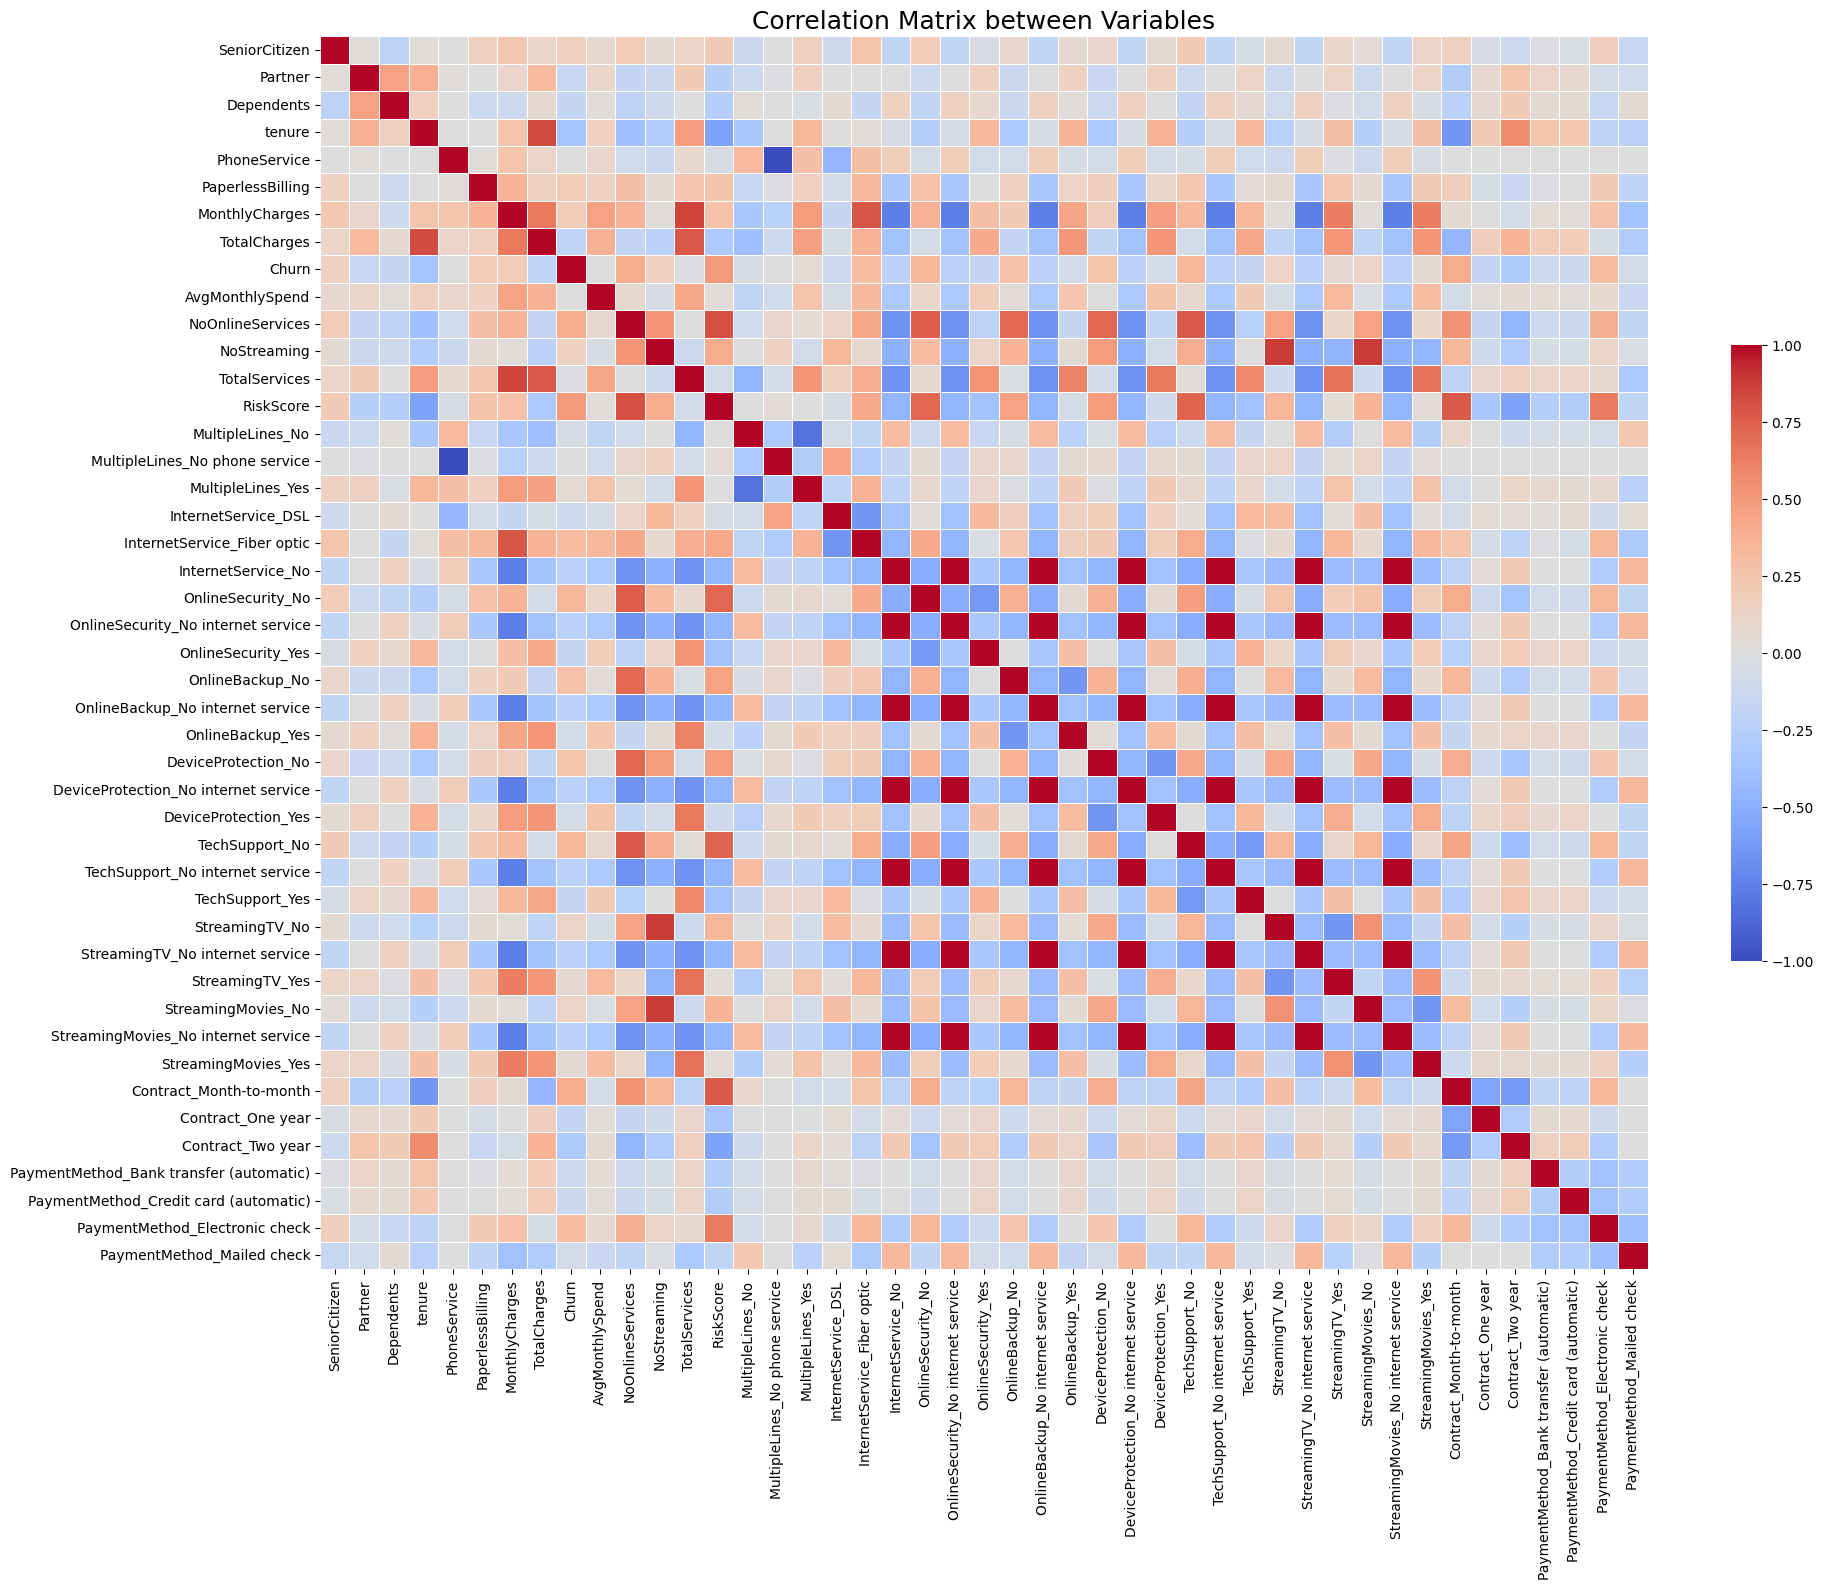

In [49]:
# Calculate the correlation matrix
corr_matrix = df_encoded.corr()

# Sets the size of the figure
plt.figure(figsize=(20, 16))

# Plot the heatmap
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, linewidths=0.5, cbar_kws={'shrink': 0.5})

# Title
plt.title('Correlation Matrix between Variables', fontsize=18)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [50]:
# Calculate the correlation of all variables with the target variable 'Churn'
churn_corr = df_encoded.corr()['Churn'].drop('Churn').sort_values(ascending=False)

# Display the list
print(churn_corr)

RiskScore                                  0.499789
NoOnlineServices                           0.405400
Contract_Month-to-month                    0.405103
OnlineSecurity_No                          0.342637
TechSupport_No                             0.337281
InternetService_Fiber optic                0.308020
PaymentMethod_Electronic check             0.301919
OnlineBackup_No                            0.268005
DeviceProtection_No                        0.252481
MonthlyCharges                             0.193356
PaperlessBilling                           0.191825
SeniorCitizen                              0.150889
NoStreaming                                0.148119
StreamingMovies_No                         0.130845
StreamingTV_No                             0.128916
StreamingTV_Yes                            0.063228
StreamingMovies_Yes                        0.061382
MultipleLines_Yes                          0.040102
AvgMonthlySpend                            0.014873
PhoneService

**Limitations of Linear Analysis**

- When applying OneHotEncoder and analyzing the correlation between variables and churn, we observed that:

- Few variables showed a strong correlation with the target variable.

- This may indicate that there are more complex non-linear relationships that are not captured by simple correlation analysis.

Therefore, we decided to complement the analysis with a tree-based model, which can capture interactions and non-linear relationships between variables.

Tree-based models, such as Random Forest, are not sensitive to the artificial scale or ordering created by LabelEncoder, and can properly handle categorical variables even when encoded as integers. Thus, we transform all categorical variables with LabelEncoder, which:

- Avoids the high dimensionality caused by OneHotEncoder, especially when we have many variables with multiple categories.

- Allows for a direct analysis of the importance of features through the model's splitting criteria (Gini or Entropy).

- Captures non-linear relationships between variables and Churn.

In [51]:
def apply_label_encoding(df):
    """
    Applies LabelEncoder to all categorical columns (type 'object') of the DataFrame.

    Parameters:
    df (pd.DataFrame): Input DataFrame

    Returns:
    pd.DataFrame: DataFrame with categorical columns encoded
    """
    df_encoded = df.copy()
    label_encoders = {}
    
    for col in df_encoded.select_dtypes(include='object').columns:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col])
        label_encoders[col] = le  # Guarda o encoder, caso queira reverter depois

    return df_encoded, label_encoders

In [52]:
df_encoded, encoders = apply_label_encoding(data_model)
df_encoded.head()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,...,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,AvgMonthlySpend,NoOnlineServices,NoStreaming,TotalServices,RiskScore
0,0,1,0,1,0,1,0,0,2,0,...,1,2,29.85,29.85,0,14.925000,3,2,2,5
1,0,0,0,34,1,0,0,2,0,2,...,0,3,56.95,1889.50,0,53.985714,2,2,4,1
2,0,0,0,2,1,0,0,2,2,0,...,1,3,53.85,108.15,1,36.050000,2,2,4,3
3,0,0,0,45,0,1,0,2,0,2,...,0,0,42.30,1840.75,0,40.016304,1,2,4,0
4,0,0,0,2,1,0,1,0,0,0,...,1,2,70.70,151.65,1,50.550000,4,2,2,5


In [53]:
df_encoded.columns

Index(['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Churn', 'AvgMonthlySpend', 'NoOnlineServices',
       'NoStreaming', 'TotalServices', 'RiskScore'],
      dtype='object')

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1294
           1       0.63      0.48      0.55       467

    accuracy                           0.79      1761
   macro avg       0.73      0.69      0.70      1761
weighted avg       0.77      0.79      0.78      1761



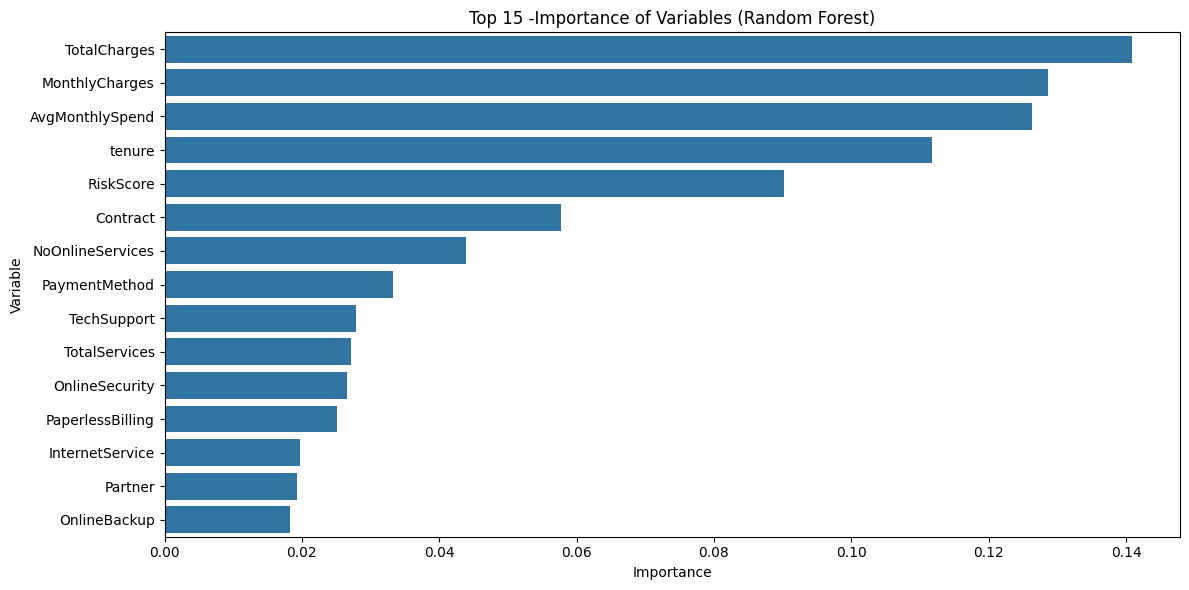

In [54]:
# 1. Prepare the data
X = df_encoded.drop(columns=['Churn'])
y = df_encoded['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

#2. Train RandomForest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 3. Evaluate model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# 4. Importance of features (Random Forest)
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=importances.values[:15], y=importances.index[:15])
plt.title("Top 15 -Importance of Variables (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()


### **5.2. Pre-Processing**

In [55]:
# 1. Apply label encoding with your function
df_encoded, label_encoders = apply_label_encoding(data_model)

# 2. Separate features and targets
X = df_encoded.drop(columns='Churn')
y = df_encoded['Churn']

#3. Split into training and testing with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#4. Apply SMOTE after split training
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 5. Initialize RandomForest with balanced class_weight
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# 6. Set parameters for GridSearch
param_grid = {
    'n_estimators': [100, 200, 400, 600],
    'max_depth': [None, 10, 20, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
    }

# 7. GridSearchCV with Cross-Validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=1)

# 8. Start MLflow experiment and run training
with mlflow.start_run(run_name="RandomForest_SMOTE_GridSearch_4_scoring_f1", nested=True) as run:
    grid_search.fit(X_resampled, y_resampled)
    
   # 9. Predictions on the original test set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # 10. Evaluating metrics
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    # 11. Log parameters of the best model
    mlflow.log_params(grid_search.best_params_)
    
    # 12. Log metrics
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    
    # 13. Log the trained model
    mlflow.sklearn.log_model(best_model, "random_forest_model")
    
    # 14. Printing the results
    print("Best parameters found:", grid_search.best_params_)
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


2025/06/17 01:37:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best parameters found: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.80      0.84      1035
           1       0.55      0.68      0.61       374

    accuracy                           0.77      1409
   macro avg       0.71      0.74      0.72      1409
weighted avg       0.79      0.77      0.78      1409

Confusion Matrix:
 [[830 205]
 [119 255]]


In [56]:
# 1. Apply label encoding with your function
df_encoded, label_encoders = apply_label_encoding(data_model)

#2. Separate resources and target
X = df_encoded.drop(columns='Churn')
y = df_encoded['Churn']

#3. Split into training and testing with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#4. Apply SMOTE after split training
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 5. Initialize XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# 6. Set parameters for GridSearch
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# 7. GridSearchCV with Cross-Validation
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=1)

# 8. Start MLflow experiment and run training
with mlflow.start_run(run_name="XGBoost_SMOTE_GridSearch_f1", nested=True) as run:
    grid_search.fit(X_resampled, y_resampled)

    # 9. Predictions on the original test set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # 10. Evaluating metrics
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    # 11. Log parameters of the best model
    mlflow.log_params(grid_search.best_params_)

    # 12. Log metrics
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)

    # 13. Log the trained model
    mlflow.sklearn.log_model(best_model, "xgboost_model")

    # 14. Printing the results
    print("Best parameters found:", grid_search.best_params_)
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 72 candidates, totalling 360 fits


d:\MLOPS\MLOPS_PROJECT_TELCO_CUSTUMER_CHURCH\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:37:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
2025/06/17 01:37:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best parameters found: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.79      0.83      1035
           1       0.55      0.71      0.62       374

    accuracy                           0.77      1409
   macro avg       0.71      0.75      0.73      1409
weighted avg       0.79      0.77      0.78      1409

Confusion Matrix:
 [[816 219]
 [109 265]]
